In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional

In [2]:
df_train = pd.read_csv('../Dataset/Corona_NLP_train.csv', encoding= 'latin-1')
df_test = pd.read_csv('../Dataset/Corona_NLP_test.csv', encoding= 'latin-1')

In [3]:
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [5]:
df = pd.concat([df_train, df_test], axis= 0, ignore_index= True)

In [6]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
df.shape

(44955, 6)

In [8]:
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [9]:
df.dtypes

UserName          int64
ScreenName        int64
Location         object
TweetAt          object
OriginalTweet    object
Sentiment        object
dtype: object

In [10]:
drop_col = df.columns[0 :4]
drop_col

Index(['UserName', 'ScreenName', 'Location', 'TweetAt'], dtype='object')

In [11]:
df.drop(columns= drop_col, axis=1, inplace= True)

In [12]:
df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [13]:
df.tail()

,OriginalTweet,Sentiment
44950,Meanwhile In A Supermarket in Israel -- People...,Positive
44951,Did you panic buy a lot of non-perishable item...,Negative
44952,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
44953,Gov need to do somethings instead of biar je r...,Extremely Negative
44954,I and @ForestandPaper members are committed to...,Extremely Positive


In [14]:
df.shape

(44955, 2)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  44955 non-null  object
 1   Sentiment      44955 non-null  object
dtypes: object(2)
memory usage: 702.5+ KB


In [16]:
df.duplicated().sum()

0

In [17]:
df.isnull().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

In [18]:
X = df['OriginalTweet']
y = df['Sentiment']

Positive              27.514181
Negative              24.375487
Neutral               18.534090
Extremely Positive    16.067178
Extremely Negative    13.509065
Name: Sentiment, dtype: float64


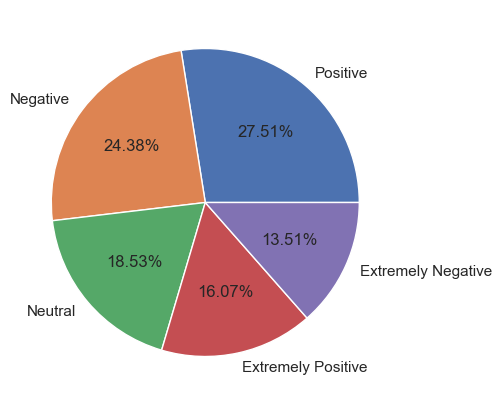

In [19]:
print(y.value_counts(normalize= True) * 100)

sns.set()
plt.figure(figsize = (5, 5))
plt.pie(x = y.value_counts().values, labels= y.value_counts().index, autopct= '%1.2f%%')
plt.show()

out_size = len(y.value_counts().values)

In [20]:
X = X.values.flatten()

In [21]:
X

array(['@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8',
       'advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order',
       'Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P',
       ...,
       "Asst Prof of Economics @cconces was on @NBCPhiladelphia talking about her recent research on coronavirus' impact on the economy. Watch it here (starting at :33): https://t.co/8tfYNoro5l",
       "Gov need to do somethings instead of biar je rakyat assume 'lockdown' ke or even worst. Harini semua supermarket crowded like hell. Lagi mudah virus tu tersebar ?? #COVID2019",
       'I and @ForestandPaper members are committed to the safety of our employees and our end-

In [22]:
ps = PorterStemmer()
stemed_corpus = []

for doc in range (0, len(X)):
    text = re.sub('[^a-zA-Z]', ' ', X[doc])
    text = text.lower()
    text = text.split()
    text = [ps.stem(word) for word in text if not word in stopwords.words('english')]
    text = ' '.join(text)
    stemed_corpus.append(text)
    
    print(f"document : {doc + 1} / {len(X)}")

document : 1 / 44955
document : 2 / 44955
document : 3 / 44955
document : 4 / 44955
document : 5 / 44955
document : 6 / 44955
document : 7 / 44955
document : 8 / 44955
document : 9 / 44955
document : 10 / 44955
document : 11 / 44955
document : 12 / 44955
document : 13 / 44955
document : 14 / 44955
document : 15 / 44955
document : 16 / 44955
document : 17 / 44955
document : 18 / 44955
document : 19 / 44955
document : 20 / 44955
document : 21 / 44955
document : 22 / 44955
document : 23 / 44955
document : 24 / 44955
document : 25 / 44955
document : 26 / 44955
document : 27 / 44955
document : 28 / 44955
document : 29 / 44955
document : 30 / 44955
document : 31 / 44955
document : 32 / 44955
document : 33 / 44955
document : 34 / 44955
document : 35 / 44955
document : 36 / 44955
document : 37 / 44955
document : 38 / 44955
document : 39 / 44955
document : 40 / 44955
document : 41 / 44955
document : 42 / 44955
document : 43 / 44955
document : 44 / 44955
document : 45 / 44955
document : 46 / 449

document : 379 / 44955
document : 380 / 44955
document : 381 / 44955
document : 382 / 44955
document : 383 / 44955
document : 384 / 44955
document : 385 / 44955
document : 386 / 44955
document : 387 / 44955
document : 388 / 44955
document : 389 / 44955
document : 390 / 44955
document : 391 / 44955
document : 392 / 44955
document : 393 / 44955
document : 394 / 44955
document : 395 / 44955
document : 396 / 44955
document : 397 / 44955
document : 398 / 44955
document : 399 / 44955
document : 400 / 44955
document : 401 / 44955
document : 402 / 44955
document : 403 / 44955
document : 404 / 44955
document : 405 / 44955
document : 406 / 44955
document : 407 / 44955
document : 408 / 44955
document : 409 / 44955
document : 410 / 44955
document : 411 / 44955
document : 412 / 44955
document : 413 / 44955
document : 414 / 44955
document : 415 / 44955
document : 416 / 44955
document : 417 / 44955
document : 418 / 44955
document : 419 / 44955
document : 420 / 44955
document : 421 / 44955
document : 

document : 767 / 44955
document : 768 / 44955
document : 769 / 44955
document : 770 / 44955
document : 771 / 44955
document : 772 / 44955
document : 773 / 44955
document : 774 / 44955
document : 775 / 44955
document : 776 / 44955
document : 777 / 44955
document : 778 / 44955
document : 779 / 44955
document : 780 / 44955
document : 781 / 44955
document : 782 / 44955
document : 783 / 44955
document : 784 / 44955
document : 785 / 44955
document : 786 / 44955
document : 787 / 44955
document : 788 / 44955
document : 789 / 44955
document : 790 / 44955
document : 791 / 44955
document : 792 / 44955
document : 793 / 44955
document : 794 / 44955
document : 795 / 44955
document : 796 / 44955
document : 797 / 44955
document : 798 / 44955
document : 799 / 44955
document : 800 / 44955
document : 801 / 44955
document : 802 / 44955
document : 803 / 44955
document : 804 / 44955
document : 805 / 44955
document : 806 / 44955
document : 807 / 44955
document : 808 / 44955
document : 809 / 44955
document : 

document : 1137 / 44955
document : 1138 / 44955
document : 1139 / 44955
document : 1140 / 44955
document : 1141 / 44955
document : 1142 / 44955
document : 1143 / 44955
document : 1144 / 44955
document : 1145 / 44955
document : 1146 / 44955
document : 1147 / 44955
document : 1148 / 44955
document : 1149 / 44955
document : 1150 / 44955
document : 1151 / 44955
document : 1152 / 44955
document : 1153 / 44955
document : 1154 / 44955
document : 1155 / 44955
document : 1156 / 44955
document : 1157 / 44955
document : 1158 / 44955
document : 1159 / 44955
document : 1160 / 44955
document : 1161 / 44955
document : 1162 / 44955
document : 1163 / 44955
document : 1164 / 44955
document : 1165 / 44955
document : 1166 / 44955
document : 1167 / 44955
document : 1168 / 44955
document : 1169 / 44955
document : 1170 / 44955
document : 1171 / 44955
document : 1172 / 44955
document : 1173 / 44955
document : 1174 / 44955
document : 1175 / 44955
document : 1176 / 44955
document : 1177 / 44955
document : 1178 

document : 1499 / 44955
document : 1500 / 44955
document : 1501 / 44955
document : 1502 / 44955
document : 1503 / 44955
document : 1504 / 44955
document : 1505 / 44955
document : 1506 / 44955
document : 1507 / 44955
document : 1508 / 44955
document : 1509 / 44955
document : 1510 / 44955
document : 1511 / 44955
document : 1512 / 44955
document : 1513 / 44955
document : 1514 / 44955
document : 1515 / 44955
document : 1516 / 44955
document : 1517 / 44955
document : 1518 / 44955
document : 1519 / 44955
document : 1520 / 44955
document : 1521 / 44955
document : 1522 / 44955
document : 1523 / 44955
document : 1524 / 44955
document : 1525 / 44955
document : 1526 / 44955
document : 1527 / 44955
document : 1528 / 44955
document : 1529 / 44955
document : 1530 / 44955
document : 1531 / 44955
document : 1532 / 44955
document : 1533 / 44955
document : 1534 / 44955
document : 1535 / 44955
document : 1536 / 44955
document : 1537 / 44955
document : 1538 / 44955
document : 1539 / 44955
document : 1540 

document : 1846 / 44955
document : 1847 / 44955
document : 1848 / 44955
document : 1849 / 44955
document : 1850 / 44955
document : 1851 / 44955
document : 1852 / 44955
document : 1853 / 44955
document : 1854 / 44955
document : 1855 / 44955
document : 1856 / 44955
document : 1857 / 44955
document : 1858 / 44955
document : 1859 / 44955
document : 1860 / 44955
document : 1861 / 44955
document : 1862 / 44955
document : 1863 / 44955
document : 1864 / 44955
document : 1865 / 44955
document : 1866 / 44955
document : 1867 / 44955
document : 1868 / 44955
document : 1869 / 44955
document : 1870 / 44955
document : 1871 / 44955
document : 1872 / 44955
document : 1873 / 44955
document : 1874 / 44955
document : 1875 / 44955
document : 1876 / 44955
document : 1877 / 44955
document : 1878 / 44955
document : 1879 / 44955
document : 1880 / 44955
document : 1881 / 44955
document : 1882 / 44955
document : 1883 / 44955
document : 1884 / 44955
document : 1885 / 44955
document : 1886 / 44955
document : 1887 

document : 2205 / 44955
document : 2206 / 44955
document : 2207 / 44955
document : 2208 / 44955
document : 2209 / 44955
document : 2210 / 44955
document : 2211 / 44955
document : 2212 / 44955
document : 2213 / 44955
document : 2214 / 44955
document : 2215 / 44955
document : 2216 / 44955
document : 2217 / 44955
document : 2218 / 44955
document : 2219 / 44955
document : 2220 / 44955
document : 2221 / 44955
document : 2222 / 44955
document : 2223 / 44955
document : 2224 / 44955
document : 2225 / 44955
document : 2226 / 44955
document : 2227 / 44955
document : 2228 / 44955
document : 2229 / 44955
document : 2230 / 44955
document : 2231 / 44955
document : 2232 / 44955
document : 2233 / 44955
document : 2234 / 44955
document : 2235 / 44955
document : 2236 / 44955
document : 2237 / 44955
document : 2238 / 44955
document : 2239 / 44955
document : 2240 / 44955
document : 2241 / 44955
document : 2242 / 44955
document : 2243 / 44955
document : 2244 / 44955
document : 2245 / 44955
document : 2246 

document : 2561 / 44955
document : 2562 / 44955
document : 2563 / 44955
document : 2564 / 44955
document : 2565 / 44955
document : 2566 / 44955
document : 2567 / 44955
document : 2568 / 44955
document : 2569 / 44955
document : 2570 / 44955
document : 2571 / 44955
document : 2572 / 44955
document : 2573 / 44955
document : 2574 / 44955
document : 2575 / 44955
document : 2576 / 44955
document : 2577 / 44955
document : 2578 / 44955
document : 2579 / 44955
document : 2580 / 44955
document : 2581 / 44955
document : 2582 / 44955
document : 2583 / 44955
document : 2584 / 44955
document : 2585 / 44955
document : 2586 / 44955
document : 2587 / 44955
document : 2588 / 44955
document : 2589 / 44955
document : 2590 / 44955
document : 2591 / 44955
document : 2592 / 44955
document : 2593 / 44955
document : 2594 / 44955
document : 2595 / 44955
document : 2596 / 44955
document : 2597 / 44955
document : 2598 / 44955
document : 2599 / 44955
document : 2600 / 44955
document : 2601 / 44955
document : 2602 

document : 2921 / 44955
document : 2922 / 44955
document : 2923 / 44955
document : 2924 / 44955
document : 2925 / 44955
document : 2926 / 44955
document : 2927 / 44955
document : 2928 / 44955
document : 2929 / 44955
document : 2930 / 44955
document : 2931 / 44955
document : 2932 / 44955
document : 2933 / 44955
document : 2934 / 44955
document : 2935 / 44955
document : 2936 / 44955
document : 2937 / 44955
document : 2938 / 44955
document : 2939 / 44955
document : 2940 / 44955
document : 2941 / 44955
document : 2942 / 44955
document : 2943 / 44955
document : 2944 / 44955
document : 2945 / 44955
document : 2946 / 44955
document : 2947 / 44955
document : 2948 / 44955
document : 2949 / 44955
document : 2950 / 44955
document : 2951 / 44955
document : 2952 / 44955
document : 2953 / 44955
document : 2954 / 44955
document : 2955 / 44955
document : 2956 / 44955
document : 2957 / 44955
document : 2958 / 44955
document : 2959 / 44955
document : 2960 / 44955
document : 2961 / 44955
document : 2962 

document : 3293 / 44955
document : 3294 / 44955
document : 3295 / 44955
document : 3296 / 44955
document : 3297 / 44955
document : 3298 / 44955
document : 3299 / 44955
document : 3300 / 44955
document : 3301 / 44955
document : 3302 / 44955
document : 3303 / 44955
document : 3304 / 44955
document : 3305 / 44955
document : 3306 / 44955
document : 3307 / 44955
document : 3308 / 44955
document : 3309 / 44955
document : 3310 / 44955
document : 3311 / 44955
document : 3312 / 44955
document : 3313 / 44955
document : 3314 / 44955
document : 3315 / 44955
document : 3316 / 44955
document : 3317 / 44955
document : 3318 / 44955
document : 3319 / 44955
document : 3320 / 44955
document : 3321 / 44955
document : 3322 / 44955
document : 3323 / 44955
document : 3324 / 44955
document : 3325 / 44955
document : 3326 / 44955
document : 3327 / 44955
document : 3328 / 44955
document : 3329 / 44955
document : 3330 / 44955
document : 3331 / 44955
document : 3332 / 44955
document : 3333 / 44955
document : 3334 

document : 3664 / 44955
document : 3665 / 44955
document : 3666 / 44955
document : 3667 / 44955
document : 3668 / 44955
document : 3669 / 44955
document : 3670 / 44955
document : 3671 / 44955
document : 3672 / 44955
document : 3673 / 44955
document : 3674 / 44955
document : 3675 / 44955
document : 3676 / 44955
document : 3677 / 44955
document : 3678 / 44955
document : 3679 / 44955
document : 3680 / 44955
document : 3681 / 44955
document : 3682 / 44955
document : 3683 / 44955
document : 3684 / 44955
document : 3685 / 44955
document : 3686 / 44955
document : 3687 / 44955
document : 3688 / 44955
document : 3689 / 44955
document : 3690 / 44955
document : 3691 / 44955
document : 3692 / 44955
document : 3693 / 44955
document : 3694 / 44955
document : 3695 / 44955
document : 3696 / 44955
document : 3697 / 44955
document : 3698 / 44955
document : 3699 / 44955
document : 3700 / 44955
document : 3701 / 44955
document : 3702 / 44955
document : 3703 / 44955
document : 3704 / 44955
document : 3705 

document : 4030 / 44955
document : 4031 / 44955
document : 4032 / 44955
document : 4033 / 44955
document : 4034 / 44955
document : 4035 / 44955
document : 4036 / 44955
document : 4037 / 44955
document : 4038 / 44955
document : 4039 / 44955
document : 4040 / 44955
document : 4041 / 44955
document : 4042 / 44955
document : 4043 / 44955
document : 4044 / 44955
document : 4045 / 44955
document : 4046 / 44955
document : 4047 / 44955
document : 4048 / 44955
document : 4049 / 44955
document : 4050 / 44955
document : 4051 / 44955
document : 4052 / 44955
document : 4053 / 44955
document : 4054 / 44955
document : 4055 / 44955
document : 4056 / 44955
document : 4057 / 44955
document : 4058 / 44955
document : 4059 / 44955
document : 4060 / 44955
document : 4061 / 44955
document : 4062 / 44955
document : 4063 / 44955
document : 4064 / 44955
document : 4065 / 44955
document : 4066 / 44955
document : 4067 / 44955
document : 4068 / 44955
document : 4069 / 44955
document : 4070 / 44955
document : 4071 

document : 4384 / 44955
document : 4385 / 44955
document : 4386 / 44955
document : 4387 / 44955
document : 4388 / 44955
document : 4389 / 44955
document : 4390 / 44955
document : 4391 / 44955
document : 4392 / 44955
document : 4393 / 44955
document : 4394 / 44955
document : 4395 / 44955
document : 4396 / 44955
document : 4397 / 44955
document : 4398 / 44955
document : 4399 / 44955
document : 4400 / 44955
document : 4401 / 44955
document : 4402 / 44955
document : 4403 / 44955
document : 4404 / 44955
document : 4405 / 44955
document : 4406 / 44955
document : 4407 / 44955
document : 4408 / 44955
document : 4409 / 44955
document : 4410 / 44955
document : 4411 / 44955
document : 4412 / 44955
document : 4413 / 44955
document : 4414 / 44955
document : 4415 / 44955
document : 4416 / 44955
document : 4417 / 44955
document : 4418 / 44955
document : 4419 / 44955
document : 4420 / 44955
document : 4421 / 44955
document : 4422 / 44955
document : 4423 / 44955
document : 4424 / 44955
document : 4425 

document : 4755 / 44955
document : 4756 / 44955
document : 4757 / 44955
document : 4758 / 44955
document : 4759 / 44955
document : 4760 / 44955
document : 4761 / 44955
document : 4762 / 44955
document : 4763 / 44955
document : 4764 / 44955
document : 4765 / 44955
document : 4766 / 44955
document : 4767 / 44955
document : 4768 / 44955
document : 4769 / 44955
document : 4770 / 44955
document : 4771 / 44955
document : 4772 / 44955
document : 4773 / 44955
document : 4774 / 44955
document : 4775 / 44955
document : 4776 / 44955
document : 4777 / 44955
document : 4778 / 44955
document : 4779 / 44955
document : 4780 / 44955
document : 4781 / 44955
document : 4782 / 44955
document : 4783 / 44955
document : 4784 / 44955
document : 4785 / 44955
document : 4786 / 44955
document : 4787 / 44955
document : 4788 / 44955
document : 4789 / 44955
document : 4790 / 44955
document : 4791 / 44955
document : 4792 / 44955
document : 4793 / 44955
document : 4794 / 44955
document : 4795 / 44955
document : 4796 

document : 5114 / 44955
document : 5115 / 44955
document : 5116 / 44955
document : 5117 / 44955
document : 5118 / 44955
document : 5119 / 44955
document : 5120 / 44955
document : 5121 / 44955
document : 5122 / 44955
document : 5123 / 44955
document : 5124 / 44955
document : 5125 / 44955
document : 5126 / 44955
document : 5127 / 44955
document : 5128 / 44955
document : 5129 / 44955
document : 5130 / 44955
document : 5131 / 44955
document : 5132 / 44955
document : 5133 / 44955
document : 5134 / 44955
document : 5135 / 44955
document : 5136 / 44955
document : 5137 / 44955
document : 5138 / 44955
document : 5139 / 44955
document : 5140 / 44955
document : 5141 / 44955
document : 5142 / 44955
document : 5143 / 44955
document : 5144 / 44955
document : 5145 / 44955
document : 5146 / 44955
document : 5147 / 44955
document : 5148 / 44955
document : 5149 / 44955
document : 5150 / 44955
document : 5151 / 44955
document : 5152 / 44955
document : 5153 / 44955
document : 5154 / 44955
document : 5155 

document : 5470 / 44955
document : 5471 / 44955
document : 5472 / 44955
document : 5473 / 44955
document : 5474 / 44955
document : 5475 / 44955
document : 5476 / 44955
document : 5477 / 44955
document : 5478 / 44955
document : 5479 / 44955
document : 5480 / 44955
document : 5481 / 44955
document : 5482 / 44955
document : 5483 / 44955
document : 5484 / 44955
document : 5485 / 44955
document : 5486 / 44955
document : 5487 / 44955
document : 5488 / 44955
document : 5489 / 44955
document : 5490 / 44955
document : 5491 / 44955
document : 5492 / 44955
document : 5493 / 44955
document : 5494 / 44955
document : 5495 / 44955
document : 5496 / 44955
document : 5497 / 44955
document : 5498 / 44955
document : 5499 / 44955
document : 5500 / 44955
document : 5501 / 44955
document : 5502 / 44955
document : 5503 / 44955
document : 5504 / 44955
document : 5505 / 44955
document : 5506 / 44955
document : 5507 / 44955
document : 5508 / 44955
document : 5509 / 44955
document : 5510 / 44955
document : 5511 

document : 5847 / 44955
document : 5848 / 44955
document : 5849 / 44955
document : 5850 / 44955
document : 5851 / 44955
document : 5852 / 44955
document : 5853 / 44955
document : 5854 / 44955
document : 5855 / 44955
document : 5856 / 44955
document : 5857 / 44955
document : 5858 / 44955
document : 5859 / 44955
document : 5860 / 44955
document : 5861 / 44955
document : 5862 / 44955
document : 5863 / 44955
document : 5864 / 44955
document : 5865 / 44955
document : 5866 / 44955
document : 5867 / 44955
document : 5868 / 44955
document : 5869 / 44955
document : 5870 / 44955
document : 5871 / 44955
document : 5872 / 44955
document : 5873 / 44955
document : 5874 / 44955
document : 5875 / 44955
document : 5876 / 44955
document : 5877 / 44955
document : 5878 / 44955
document : 5879 / 44955
document : 5880 / 44955
document : 5881 / 44955
document : 5882 / 44955
document : 5883 / 44955
document : 5884 / 44955
document : 5885 / 44955
document : 5886 / 44955
document : 5887 / 44955
document : 5888 

document : 6208 / 44955
document : 6209 / 44955
document : 6210 / 44955
document : 6211 / 44955
document : 6212 / 44955
document : 6213 / 44955
document : 6214 / 44955
document : 6215 / 44955
document : 6216 / 44955
document : 6217 / 44955
document : 6218 / 44955
document : 6219 / 44955
document : 6220 / 44955
document : 6221 / 44955
document : 6222 / 44955
document : 6223 / 44955
document : 6224 / 44955
document : 6225 / 44955
document : 6226 / 44955
document : 6227 / 44955
document : 6228 / 44955
document : 6229 / 44955
document : 6230 / 44955
document : 6231 / 44955
document : 6232 / 44955
document : 6233 / 44955
document : 6234 / 44955
document : 6235 / 44955
document : 6236 / 44955
document : 6237 / 44955
document : 6238 / 44955
document : 6239 / 44955
document : 6240 / 44955
document : 6241 / 44955
document : 6242 / 44955
document : 6243 / 44955
document : 6244 / 44955
document : 6245 / 44955
document : 6246 / 44955
document : 6247 / 44955
document : 6248 / 44955
document : 6249 

document : 6578 / 44955
document : 6579 / 44955
document : 6580 / 44955
document : 6581 / 44955
document : 6582 / 44955
document : 6583 / 44955
document : 6584 / 44955
document : 6585 / 44955
document : 6586 / 44955
document : 6587 / 44955
document : 6588 / 44955
document : 6589 / 44955
document : 6590 / 44955
document : 6591 / 44955
document : 6592 / 44955
document : 6593 / 44955
document : 6594 / 44955
document : 6595 / 44955
document : 6596 / 44955
document : 6597 / 44955
document : 6598 / 44955
document : 6599 / 44955
document : 6600 / 44955
document : 6601 / 44955
document : 6602 / 44955
document : 6603 / 44955
document : 6604 / 44955
document : 6605 / 44955
document : 6606 / 44955
document : 6607 / 44955
document : 6608 / 44955
document : 6609 / 44955
document : 6610 / 44955
document : 6611 / 44955
document : 6612 / 44955
document : 6613 / 44955
document : 6614 / 44955
document : 6615 / 44955
document : 6616 / 44955
document : 6617 / 44955
document : 6618 / 44955
document : 6619 

document : 6935 / 44955
document : 6936 / 44955
document : 6937 / 44955
document : 6938 / 44955
document : 6939 / 44955
document : 6940 / 44955
document : 6941 / 44955
document : 6942 / 44955
document : 6943 / 44955
document : 6944 / 44955
document : 6945 / 44955
document : 6946 / 44955
document : 6947 / 44955
document : 6948 / 44955
document : 6949 / 44955
document : 6950 / 44955
document : 6951 / 44955
document : 6952 / 44955
document : 6953 / 44955
document : 6954 / 44955
document : 6955 / 44955
document : 6956 / 44955
document : 6957 / 44955
document : 6958 / 44955
document : 6959 / 44955
document : 6960 / 44955
document : 6961 / 44955
document : 6962 / 44955
document : 6963 / 44955
document : 6964 / 44955
document : 6965 / 44955
document : 6966 / 44955
document : 6967 / 44955
document : 6968 / 44955
document : 6969 / 44955
document : 6970 / 44955
document : 6971 / 44955
document : 6972 / 44955
document : 6973 / 44955
document : 6974 / 44955
document : 6975 / 44955
document : 6976 

document : 7311 / 44955
document : 7312 / 44955
document : 7313 / 44955
document : 7314 / 44955
document : 7315 / 44955
document : 7316 / 44955
document : 7317 / 44955
document : 7318 / 44955
document : 7319 / 44955
document : 7320 / 44955
document : 7321 / 44955
document : 7322 / 44955
document : 7323 / 44955
document : 7324 / 44955
document : 7325 / 44955
document : 7326 / 44955
document : 7327 / 44955
document : 7328 / 44955
document : 7329 / 44955
document : 7330 / 44955
document : 7331 / 44955
document : 7332 / 44955
document : 7333 / 44955
document : 7334 / 44955
document : 7335 / 44955
document : 7336 / 44955
document : 7337 / 44955
document : 7338 / 44955
document : 7339 / 44955
document : 7340 / 44955
document : 7341 / 44955
document : 7342 / 44955
document : 7343 / 44955
document : 7344 / 44955
document : 7345 / 44955
document : 7346 / 44955
document : 7347 / 44955
document : 7348 / 44955
document : 7349 / 44955
document : 7350 / 44955
document : 7351 / 44955
document : 7352 

document : 7664 / 44955
document : 7665 / 44955
document : 7666 / 44955
document : 7667 / 44955
document : 7668 / 44955
document : 7669 / 44955
document : 7670 / 44955
document : 7671 / 44955
document : 7672 / 44955
document : 7673 / 44955
document : 7674 / 44955
document : 7675 / 44955
document : 7676 / 44955
document : 7677 / 44955
document : 7678 / 44955
document : 7679 / 44955
document : 7680 / 44955
document : 7681 / 44955
document : 7682 / 44955
document : 7683 / 44955
document : 7684 / 44955
document : 7685 / 44955
document : 7686 / 44955
document : 7687 / 44955
document : 7688 / 44955
document : 7689 / 44955
document : 7690 / 44955
document : 7691 / 44955
document : 7692 / 44955
document : 7693 / 44955
document : 7694 / 44955
document : 7695 / 44955
document : 7696 / 44955
document : 7697 / 44955
document : 7698 / 44955
document : 7699 / 44955
document : 7700 / 44955
document : 7701 / 44955
document : 7702 / 44955
document : 7703 / 44955
document : 7704 / 44955
document : 7705 

document : 8009 / 44955
document : 8010 / 44955
document : 8011 / 44955
document : 8012 / 44955
document : 8013 / 44955
document : 8014 / 44955
document : 8015 / 44955
document : 8016 / 44955
document : 8017 / 44955
document : 8018 / 44955
document : 8019 / 44955
document : 8020 / 44955
document : 8021 / 44955
document : 8022 / 44955
document : 8023 / 44955
document : 8024 / 44955
document : 8025 / 44955
document : 8026 / 44955
document : 8027 / 44955
document : 8028 / 44955
document : 8029 / 44955
document : 8030 / 44955
document : 8031 / 44955
document : 8032 / 44955
document : 8033 / 44955
document : 8034 / 44955
document : 8035 / 44955
document : 8036 / 44955
document : 8037 / 44955
document : 8038 / 44955
document : 8039 / 44955
document : 8040 / 44955
document : 8041 / 44955
document : 8042 / 44955
document : 8043 / 44955
document : 8044 / 44955
document : 8045 / 44955
document : 8046 / 44955
document : 8047 / 44955
document : 8048 / 44955
document : 8049 / 44955
document : 8050 

document : 8356 / 44955
document : 8357 / 44955
document : 8358 / 44955
document : 8359 / 44955
document : 8360 / 44955
document : 8361 / 44955
document : 8362 / 44955
document : 8363 / 44955
document : 8364 / 44955
document : 8365 / 44955
document : 8366 / 44955
document : 8367 / 44955
document : 8368 / 44955
document : 8369 / 44955
document : 8370 / 44955
document : 8371 / 44955
document : 8372 / 44955
document : 8373 / 44955
document : 8374 / 44955
document : 8375 / 44955
document : 8376 / 44955
document : 8377 / 44955
document : 8378 / 44955
document : 8379 / 44955
document : 8380 / 44955
document : 8381 / 44955
document : 8382 / 44955
document : 8383 / 44955
document : 8384 / 44955
document : 8385 / 44955
document : 8386 / 44955
document : 8387 / 44955
document : 8388 / 44955
document : 8389 / 44955
document : 8390 / 44955
document : 8391 / 44955
document : 8392 / 44955
document : 8393 / 44955
document : 8394 / 44955
document : 8395 / 44955
document : 8396 / 44955
document : 8397 

document : 8707 / 44955
document : 8708 / 44955
document : 8709 / 44955
document : 8710 / 44955
document : 8711 / 44955
document : 8712 / 44955
document : 8713 / 44955
document : 8714 / 44955
document : 8715 / 44955
document : 8716 / 44955
document : 8717 / 44955
document : 8718 / 44955
document : 8719 / 44955
document : 8720 / 44955
document : 8721 / 44955
document : 8722 / 44955
document : 8723 / 44955
document : 8724 / 44955
document : 8725 / 44955
document : 8726 / 44955
document : 8727 / 44955
document : 8728 / 44955
document : 8729 / 44955
document : 8730 / 44955
document : 8731 / 44955
document : 8732 / 44955
document : 8733 / 44955
document : 8734 / 44955
document : 8735 / 44955
document : 8736 / 44955
document : 8737 / 44955
document : 8738 / 44955
document : 8739 / 44955
document : 8740 / 44955
document : 8741 / 44955
document : 8742 / 44955
document : 8743 / 44955
document : 8744 / 44955
document : 8745 / 44955
document : 8746 / 44955
document : 8747 / 44955
document : 8748 

document : 9057 / 44955
document : 9058 / 44955
document : 9059 / 44955
document : 9060 / 44955
document : 9061 / 44955
document : 9062 / 44955
document : 9063 / 44955
document : 9064 / 44955
document : 9065 / 44955
document : 9066 / 44955
document : 9067 / 44955
document : 9068 / 44955
document : 9069 / 44955
document : 9070 / 44955
document : 9071 / 44955
document : 9072 / 44955
document : 9073 / 44955
document : 9074 / 44955
document : 9075 / 44955
document : 9076 / 44955
document : 9077 / 44955
document : 9078 / 44955
document : 9079 / 44955
document : 9080 / 44955
document : 9081 / 44955
document : 9082 / 44955
document : 9083 / 44955
document : 9084 / 44955
document : 9085 / 44955
document : 9086 / 44955
document : 9087 / 44955
document : 9088 / 44955
document : 9089 / 44955
document : 9090 / 44955
document : 9091 / 44955
document : 9092 / 44955
document : 9093 / 44955
document : 9094 / 44955
document : 9095 / 44955
document : 9096 / 44955
document : 9097 / 44955
document : 9098 

document : 9400 / 44955
document : 9401 / 44955
document : 9402 / 44955
document : 9403 / 44955
document : 9404 / 44955
document : 9405 / 44955
document : 9406 / 44955
document : 9407 / 44955
document : 9408 / 44955
document : 9409 / 44955
document : 9410 / 44955
document : 9411 / 44955
document : 9412 / 44955
document : 9413 / 44955
document : 9414 / 44955
document : 9415 / 44955
document : 9416 / 44955
document : 9417 / 44955
document : 9418 / 44955
document : 9419 / 44955
document : 9420 / 44955
document : 9421 / 44955
document : 9422 / 44955
document : 9423 / 44955
document : 9424 / 44955
document : 9425 / 44955
document : 9426 / 44955
document : 9427 / 44955
document : 9428 / 44955
document : 9429 / 44955
document : 9430 / 44955
document : 9431 / 44955
document : 9432 / 44955
document : 9433 / 44955
document : 9434 / 44955
document : 9435 / 44955
document : 9436 / 44955
document : 9437 / 44955
document : 9438 / 44955
document : 9439 / 44955
document : 9440 / 44955
document : 9441 

document : 9746 / 44955
document : 9747 / 44955
document : 9748 / 44955
document : 9749 / 44955
document : 9750 / 44955
document : 9751 / 44955
document : 9752 / 44955
document : 9753 / 44955
document : 9754 / 44955
document : 9755 / 44955
document : 9756 / 44955
document : 9757 / 44955
document : 9758 / 44955
document : 9759 / 44955
document : 9760 / 44955
document : 9761 / 44955
document : 9762 / 44955
document : 9763 / 44955
document : 9764 / 44955
document : 9765 / 44955
document : 9766 / 44955
document : 9767 / 44955
document : 9768 / 44955
document : 9769 / 44955
document : 9770 / 44955
document : 9771 / 44955
document : 9772 / 44955
document : 9773 / 44955
document : 9774 / 44955
document : 9775 / 44955
document : 9776 / 44955
document : 9777 / 44955
document : 9778 / 44955
document : 9779 / 44955
document : 9780 / 44955
document : 9781 / 44955
document : 9782 / 44955
document : 9783 / 44955
document : 9784 / 44955
document : 9785 / 44955
document : 9786 / 44955
document : 9787 

document : 10097 / 44955
document : 10098 / 44955
document : 10099 / 44955
document : 10100 / 44955
document : 10101 / 44955
document : 10102 / 44955
document : 10103 / 44955
document : 10104 / 44955
document : 10105 / 44955
document : 10106 / 44955
document : 10107 / 44955
document : 10108 / 44955
document : 10109 / 44955
document : 10110 / 44955
document : 10111 / 44955
document : 10112 / 44955
document : 10113 / 44955
document : 10114 / 44955
document : 10115 / 44955
document : 10116 / 44955
document : 10117 / 44955
document : 10118 / 44955
document : 10119 / 44955
document : 10120 / 44955
document : 10121 / 44955
document : 10122 / 44955
document : 10123 / 44955
document : 10124 / 44955
document : 10125 / 44955
document : 10126 / 44955
document : 10127 / 44955
document : 10128 / 44955
document : 10129 / 44955
document : 10130 / 44955
document : 10131 / 44955
document : 10132 / 44955
document : 10133 / 44955
document : 10134 / 44955
document : 10135 / 44955
document : 10136 / 44955


document : 10444 / 44955
document : 10445 / 44955
document : 10446 / 44955
document : 10447 / 44955
document : 10448 / 44955
document : 10449 / 44955
document : 10450 / 44955
document : 10451 / 44955
document : 10452 / 44955
document : 10453 / 44955
document : 10454 / 44955
document : 10455 / 44955
document : 10456 / 44955
document : 10457 / 44955
document : 10458 / 44955
document : 10459 / 44955
document : 10460 / 44955
document : 10461 / 44955
document : 10462 / 44955
document : 10463 / 44955
document : 10464 / 44955
document : 10465 / 44955
document : 10466 / 44955
document : 10467 / 44955
document : 10468 / 44955
document : 10469 / 44955
document : 10470 / 44955
document : 10471 / 44955
document : 10472 / 44955
document : 10473 / 44955
document : 10474 / 44955
document : 10475 / 44955
document : 10476 / 44955
document : 10477 / 44955
document : 10478 / 44955
document : 10479 / 44955
document : 10480 / 44955
document : 10481 / 44955
document : 10482 / 44955
document : 10483 / 44955


document : 10783 / 44955
document : 10784 / 44955
document : 10785 / 44955
document : 10786 / 44955
document : 10787 / 44955
document : 10788 / 44955
document : 10789 / 44955
document : 10790 / 44955
document : 10791 / 44955
document : 10792 / 44955
document : 10793 / 44955
document : 10794 / 44955
document : 10795 / 44955
document : 10796 / 44955
document : 10797 / 44955
document : 10798 / 44955
document : 10799 / 44955
document : 10800 / 44955
document : 10801 / 44955
document : 10802 / 44955
document : 10803 / 44955
document : 10804 / 44955
document : 10805 / 44955
document : 10806 / 44955
document : 10807 / 44955
document : 10808 / 44955
document : 10809 / 44955
document : 10810 / 44955
document : 10811 / 44955
document : 10812 / 44955
document : 10813 / 44955
document : 10814 / 44955
document : 10815 / 44955
document : 10816 / 44955
document : 10817 / 44955
document : 10818 / 44955
document : 10819 / 44955
document : 10820 / 44955
document : 10821 / 44955
document : 10822 / 44955


document : 11123 / 44955
document : 11124 / 44955
document : 11125 / 44955
document : 11126 / 44955
document : 11127 / 44955
document : 11128 / 44955
document : 11129 / 44955
document : 11130 / 44955
document : 11131 / 44955
document : 11132 / 44955
document : 11133 / 44955
document : 11134 / 44955
document : 11135 / 44955
document : 11136 / 44955
document : 11137 / 44955
document : 11138 / 44955
document : 11139 / 44955
document : 11140 / 44955
document : 11141 / 44955
document : 11142 / 44955
document : 11143 / 44955
document : 11144 / 44955
document : 11145 / 44955
document : 11146 / 44955
document : 11147 / 44955
document : 11148 / 44955
document : 11149 / 44955
document : 11150 / 44955
document : 11151 / 44955
document : 11152 / 44955
document : 11153 / 44955
document : 11154 / 44955
document : 11155 / 44955
document : 11156 / 44955
document : 11157 / 44955
document : 11158 / 44955
document : 11159 / 44955
document : 11160 / 44955
document : 11161 / 44955
document : 11162 / 44955


document : 11467 / 44955
document : 11468 / 44955
document : 11469 / 44955
document : 11470 / 44955
document : 11471 / 44955
document : 11472 / 44955
document : 11473 / 44955
document : 11474 / 44955
document : 11475 / 44955
document : 11476 / 44955
document : 11477 / 44955
document : 11478 / 44955
document : 11479 / 44955
document : 11480 / 44955
document : 11481 / 44955
document : 11482 / 44955
document : 11483 / 44955
document : 11484 / 44955
document : 11485 / 44955
document : 11486 / 44955
document : 11487 / 44955
document : 11488 / 44955
document : 11489 / 44955
document : 11490 / 44955
document : 11491 / 44955
document : 11492 / 44955
document : 11493 / 44955
document : 11494 / 44955
document : 11495 / 44955
document : 11496 / 44955
document : 11497 / 44955
document : 11498 / 44955
document : 11499 / 44955
document : 11500 / 44955
document : 11501 / 44955
document : 11502 / 44955
document : 11503 / 44955
document : 11504 / 44955
document : 11505 / 44955
document : 11506 / 44955


document : 11805 / 44955
document : 11806 / 44955
document : 11807 / 44955
document : 11808 / 44955
document : 11809 / 44955
document : 11810 / 44955
document : 11811 / 44955
document : 11812 / 44955
document : 11813 / 44955
document : 11814 / 44955
document : 11815 / 44955
document : 11816 / 44955
document : 11817 / 44955
document : 11818 / 44955
document : 11819 / 44955
document : 11820 / 44955
document : 11821 / 44955
document : 11822 / 44955
document : 11823 / 44955
document : 11824 / 44955
document : 11825 / 44955
document : 11826 / 44955
document : 11827 / 44955
document : 11828 / 44955
document : 11829 / 44955
document : 11830 / 44955
document : 11831 / 44955
document : 11832 / 44955
document : 11833 / 44955
document : 11834 / 44955
document : 11835 / 44955
document : 11836 / 44955
document : 11837 / 44955
document : 11838 / 44955
document : 11839 / 44955
document : 11840 / 44955
document : 11841 / 44955
document : 11842 / 44955
document : 11843 / 44955
document : 11844 / 44955


document : 12142 / 44955
document : 12143 / 44955
document : 12144 / 44955
document : 12145 / 44955
document : 12146 / 44955
document : 12147 / 44955
document : 12148 / 44955
document : 12149 / 44955
document : 12150 / 44955
document : 12151 / 44955
document : 12152 / 44955
document : 12153 / 44955
document : 12154 / 44955
document : 12155 / 44955
document : 12156 / 44955
document : 12157 / 44955
document : 12158 / 44955
document : 12159 / 44955
document : 12160 / 44955
document : 12161 / 44955
document : 12162 / 44955
document : 12163 / 44955
document : 12164 / 44955
document : 12165 / 44955
document : 12166 / 44955
document : 12167 / 44955
document : 12168 / 44955
document : 12169 / 44955
document : 12170 / 44955
document : 12171 / 44955
document : 12172 / 44955
document : 12173 / 44955
document : 12174 / 44955
document : 12175 / 44955
document : 12176 / 44955
document : 12177 / 44955
document : 12178 / 44955
document : 12179 / 44955
document : 12180 / 44955
document : 12181 / 44955


document : 12485 / 44955
document : 12486 / 44955
document : 12487 / 44955
document : 12488 / 44955
document : 12489 / 44955
document : 12490 / 44955
document : 12491 / 44955
document : 12492 / 44955
document : 12493 / 44955
document : 12494 / 44955
document : 12495 / 44955
document : 12496 / 44955
document : 12497 / 44955
document : 12498 / 44955
document : 12499 / 44955
document : 12500 / 44955
document : 12501 / 44955
document : 12502 / 44955
document : 12503 / 44955
document : 12504 / 44955
document : 12505 / 44955
document : 12506 / 44955
document : 12507 / 44955
document : 12508 / 44955
document : 12509 / 44955
document : 12510 / 44955
document : 12511 / 44955
document : 12512 / 44955
document : 12513 / 44955
document : 12514 / 44955
document : 12515 / 44955
document : 12516 / 44955
document : 12517 / 44955
document : 12518 / 44955
document : 12519 / 44955
document : 12520 / 44955
document : 12521 / 44955
document : 12522 / 44955
document : 12523 / 44955
document : 12524 / 44955


document : 12840 / 44955
document : 12841 / 44955
document : 12842 / 44955
document : 12843 / 44955
document : 12844 / 44955
document : 12845 / 44955
document : 12846 / 44955
document : 12847 / 44955
document : 12848 / 44955
document : 12849 / 44955
document : 12850 / 44955
document : 12851 / 44955
document : 12852 / 44955
document : 12853 / 44955
document : 12854 / 44955
document : 12855 / 44955
document : 12856 / 44955
document : 12857 / 44955
document : 12858 / 44955
document : 12859 / 44955
document : 12860 / 44955
document : 12861 / 44955
document : 12862 / 44955
document : 12863 / 44955
document : 12864 / 44955
document : 12865 / 44955
document : 12866 / 44955
document : 12867 / 44955
document : 12868 / 44955
document : 12869 / 44955
document : 12870 / 44955
document : 12871 / 44955
document : 12872 / 44955
document : 12873 / 44955
document : 12874 / 44955
document : 12875 / 44955
document : 12876 / 44955
document : 12877 / 44955
document : 12878 / 44955
document : 12879 / 44955


document : 13184 / 44955
document : 13185 / 44955
document : 13186 / 44955
document : 13187 / 44955
document : 13188 / 44955
document : 13189 / 44955
document : 13190 / 44955
document : 13191 / 44955
document : 13192 / 44955
document : 13193 / 44955
document : 13194 / 44955
document : 13195 / 44955
document : 13196 / 44955
document : 13197 / 44955
document : 13198 / 44955
document : 13199 / 44955
document : 13200 / 44955
document : 13201 / 44955
document : 13202 / 44955
document : 13203 / 44955
document : 13204 / 44955
document : 13205 / 44955
document : 13206 / 44955
document : 13207 / 44955
document : 13208 / 44955
document : 13209 / 44955
document : 13210 / 44955
document : 13211 / 44955
document : 13212 / 44955
document : 13213 / 44955
document : 13214 / 44955
document : 13215 / 44955
document : 13216 / 44955
document : 13217 / 44955
document : 13218 / 44955
document : 13219 / 44955
document : 13220 / 44955
document : 13221 / 44955
document : 13222 / 44955
document : 13223 / 44955


document : 13516 / 44955
document : 13517 / 44955
document : 13518 / 44955
document : 13519 / 44955
document : 13520 / 44955
document : 13521 / 44955
document : 13522 / 44955
document : 13523 / 44955
document : 13524 / 44955
document : 13525 / 44955
document : 13526 / 44955
document : 13527 / 44955
document : 13528 / 44955
document : 13529 / 44955
document : 13530 / 44955
document : 13531 / 44955
document : 13532 / 44955
document : 13533 / 44955
document : 13534 / 44955
document : 13535 / 44955
document : 13536 / 44955
document : 13537 / 44955
document : 13538 / 44955
document : 13539 / 44955
document : 13540 / 44955
document : 13541 / 44955
document : 13542 / 44955
document : 13543 / 44955
document : 13544 / 44955
document : 13545 / 44955
document : 13546 / 44955
document : 13547 / 44955
document : 13548 / 44955
document : 13549 / 44955
document : 13550 / 44955
document : 13551 / 44955
document : 13552 / 44955
document : 13553 / 44955
document : 13554 / 44955
document : 13555 / 44955


document : 13858 / 44955
document : 13859 / 44955
document : 13860 / 44955
document : 13861 / 44955
document : 13862 / 44955
document : 13863 / 44955
document : 13864 / 44955
document : 13865 / 44955
document : 13866 / 44955
document : 13867 / 44955
document : 13868 / 44955
document : 13869 / 44955
document : 13870 / 44955
document : 13871 / 44955
document : 13872 / 44955
document : 13873 / 44955
document : 13874 / 44955
document : 13875 / 44955
document : 13876 / 44955
document : 13877 / 44955
document : 13878 / 44955
document : 13879 / 44955
document : 13880 / 44955
document : 13881 / 44955
document : 13882 / 44955
document : 13883 / 44955
document : 13884 / 44955
document : 13885 / 44955
document : 13886 / 44955
document : 13887 / 44955
document : 13888 / 44955
document : 13889 / 44955
document : 13890 / 44955
document : 13891 / 44955
document : 13892 / 44955
document : 13893 / 44955
document : 13894 / 44955
document : 13895 / 44955
document : 13896 / 44955
document : 13897 / 44955


document : 14213 / 44955
document : 14214 / 44955
document : 14215 / 44955
document : 14216 / 44955
document : 14217 / 44955
document : 14218 / 44955
document : 14219 / 44955
document : 14220 / 44955
document : 14221 / 44955
document : 14222 / 44955
document : 14223 / 44955
document : 14224 / 44955
document : 14225 / 44955
document : 14226 / 44955
document : 14227 / 44955
document : 14228 / 44955
document : 14229 / 44955
document : 14230 / 44955
document : 14231 / 44955
document : 14232 / 44955
document : 14233 / 44955
document : 14234 / 44955
document : 14235 / 44955
document : 14236 / 44955
document : 14237 / 44955
document : 14238 / 44955
document : 14239 / 44955
document : 14240 / 44955
document : 14241 / 44955
document : 14242 / 44955
document : 14243 / 44955
document : 14244 / 44955
document : 14245 / 44955
document : 14246 / 44955
document : 14247 / 44955
document : 14248 / 44955
document : 14249 / 44955
document : 14250 / 44955
document : 14251 / 44955
document : 14252 / 44955


document : 14543 / 44955
document : 14544 / 44955
document : 14545 / 44955
document : 14546 / 44955
document : 14547 / 44955
document : 14548 / 44955
document : 14549 / 44955
document : 14550 / 44955
document : 14551 / 44955
document : 14552 / 44955
document : 14553 / 44955
document : 14554 / 44955
document : 14555 / 44955
document : 14556 / 44955
document : 14557 / 44955
document : 14558 / 44955
document : 14559 / 44955
document : 14560 / 44955
document : 14561 / 44955
document : 14562 / 44955
document : 14563 / 44955
document : 14564 / 44955
document : 14565 / 44955
document : 14566 / 44955
document : 14567 / 44955
document : 14568 / 44955
document : 14569 / 44955
document : 14570 / 44955
document : 14571 / 44955
document : 14572 / 44955
document : 14573 / 44955
document : 14574 / 44955
document : 14575 / 44955
document : 14576 / 44955
document : 14577 / 44955
document : 14578 / 44955
document : 14579 / 44955
document : 14580 / 44955
document : 14581 / 44955
document : 14582 / 44955


document : 14873 / 44955
document : 14874 / 44955
document : 14875 / 44955
document : 14876 / 44955
document : 14877 / 44955
document : 14878 / 44955
document : 14879 / 44955
document : 14880 / 44955
document : 14881 / 44955
document : 14882 / 44955
document : 14883 / 44955
document : 14884 / 44955
document : 14885 / 44955
document : 14886 / 44955
document : 14887 / 44955
document : 14888 / 44955
document : 14889 / 44955
document : 14890 / 44955
document : 14891 / 44955
document : 14892 / 44955
document : 14893 / 44955
document : 14894 / 44955
document : 14895 / 44955
document : 14896 / 44955
document : 14897 / 44955
document : 14898 / 44955
document : 14899 / 44955
document : 14900 / 44955
document : 14901 / 44955
document : 14902 / 44955
document : 14903 / 44955
document : 14904 / 44955
document : 14905 / 44955
document : 14906 / 44955
document : 14907 / 44955
document : 14908 / 44955
document : 14909 / 44955
document : 14910 / 44955
document : 14911 / 44955
document : 14912 / 44955


document : 15210 / 44955
document : 15211 / 44955
document : 15212 / 44955
document : 15213 / 44955
document : 15214 / 44955
document : 15215 / 44955
document : 15216 / 44955
document : 15217 / 44955
document : 15218 / 44955
document : 15219 / 44955
document : 15220 / 44955
document : 15221 / 44955
document : 15222 / 44955
document : 15223 / 44955
document : 15224 / 44955
document : 15225 / 44955
document : 15226 / 44955
document : 15227 / 44955
document : 15228 / 44955
document : 15229 / 44955
document : 15230 / 44955
document : 15231 / 44955
document : 15232 / 44955
document : 15233 / 44955
document : 15234 / 44955
document : 15235 / 44955
document : 15236 / 44955
document : 15237 / 44955
document : 15238 / 44955
document : 15239 / 44955
document : 15240 / 44955
document : 15241 / 44955
document : 15242 / 44955
document : 15243 / 44955
document : 15244 / 44955
document : 15245 / 44955
document : 15246 / 44955
document : 15247 / 44955
document : 15248 / 44955
document : 15249 / 44955


document : 15551 / 44955
document : 15552 / 44955
document : 15553 / 44955
document : 15554 / 44955
document : 15555 / 44955
document : 15556 / 44955
document : 15557 / 44955
document : 15558 / 44955
document : 15559 / 44955
document : 15560 / 44955
document : 15561 / 44955
document : 15562 / 44955
document : 15563 / 44955
document : 15564 / 44955
document : 15565 / 44955
document : 15566 / 44955
document : 15567 / 44955
document : 15568 / 44955
document : 15569 / 44955
document : 15570 / 44955
document : 15571 / 44955
document : 15572 / 44955
document : 15573 / 44955
document : 15574 / 44955
document : 15575 / 44955
document : 15576 / 44955
document : 15577 / 44955
document : 15578 / 44955
document : 15579 / 44955
document : 15580 / 44955
document : 15581 / 44955
document : 15582 / 44955
document : 15583 / 44955
document : 15584 / 44955
document : 15585 / 44955
document : 15586 / 44955
document : 15587 / 44955
document : 15588 / 44955
document : 15589 / 44955
document : 15590 / 44955


document : 15886 / 44955
document : 15887 / 44955
document : 15888 / 44955
document : 15889 / 44955
document : 15890 / 44955
document : 15891 / 44955
document : 15892 / 44955
document : 15893 / 44955
document : 15894 / 44955
document : 15895 / 44955
document : 15896 / 44955
document : 15897 / 44955
document : 15898 / 44955
document : 15899 / 44955
document : 15900 / 44955
document : 15901 / 44955
document : 15902 / 44955
document : 15903 / 44955
document : 15904 / 44955
document : 15905 / 44955
document : 15906 / 44955
document : 15907 / 44955
document : 15908 / 44955
document : 15909 / 44955
document : 15910 / 44955
document : 15911 / 44955
document : 15912 / 44955
document : 15913 / 44955
document : 15914 / 44955
document : 15915 / 44955
document : 15916 / 44955
document : 15917 / 44955
document : 15918 / 44955
document : 15919 / 44955
document : 15920 / 44955
document : 15921 / 44955
document : 15922 / 44955
document : 15923 / 44955
document : 15924 / 44955
document : 15925 / 44955


document : 16239 / 44955
document : 16240 / 44955
document : 16241 / 44955
document : 16242 / 44955
document : 16243 / 44955
document : 16244 / 44955
document : 16245 / 44955
document : 16246 / 44955
document : 16247 / 44955
document : 16248 / 44955
document : 16249 / 44955
document : 16250 / 44955
document : 16251 / 44955
document : 16252 / 44955
document : 16253 / 44955
document : 16254 / 44955
document : 16255 / 44955
document : 16256 / 44955
document : 16257 / 44955
document : 16258 / 44955
document : 16259 / 44955
document : 16260 / 44955
document : 16261 / 44955
document : 16262 / 44955
document : 16263 / 44955
document : 16264 / 44955
document : 16265 / 44955
document : 16266 / 44955
document : 16267 / 44955
document : 16268 / 44955
document : 16269 / 44955
document : 16270 / 44955
document : 16271 / 44955
document : 16272 / 44955
document : 16273 / 44955
document : 16274 / 44955
document : 16275 / 44955
document : 16276 / 44955
document : 16277 / 44955
document : 16278 / 44955


document : 16572 / 44955
document : 16573 / 44955
document : 16574 / 44955
document : 16575 / 44955
document : 16576 / 44955
document : 16577 / 44955
document : 16578 / 44955
document : 16579 / 44955
document : 16580 / 44955
document : 16581 / 44955
document : 16582 / 44955
document : 16583 / 44955
document : 16584 / 44955
document : 16585 / 44955
document : 16586 / 44955
document : 16587 / 44955
document : 16588 / 44955
document : 16589 / 44955
document : 16590 / 44955
document : 16591 / 44955
document : 16592 / 44955
document : 16593 / 44955
document : 16594 / 44955
document : 16595 / 44955
document : 16596 / 44955
document : 16597 / 44955
document : 16598 / 44955
document : 16599 / 44955
document : 16600 / 44955
document : 16601 / 44955
document : 16602 / 44955
document : 16603 / 44955
document : 16604 / 44955
document : 16605 / 44955
document : 16606 / 44955
document : 16607 / 44955
document : 16608 / 44955
document : 16609 / 44955
document : 16610 / 44955
document : 16611 / 44955


document : 16923 / 44955
document : 16924 / 44955
document : 16925 / 44955
document : 16926 / 44955
document : 16927 / 44955
document : 16928 / 44955
document : 16929 / 44955
document : 16930 / 44955
document : 16931 / 44955
document : 16932 / 44955
document : 16933 / 44955
document : 16934 / 44955
document : 16935 / 44955
document : 16936 / 44955
document : 16937 / 44955
document : 16938 / 44955
document : 16939 / 44955
document : 16940 / 44955
document : 16941 / 44955
document : 16942 / 44955
document : 16943 / 44955
document : 16944 / 44955
document : 16945 / 44955
document : 16946 / 44955
document : 16947 / 44955
document : 16948 / 44955
document : 16949 / 44955
document : 16950 / 44955
document : 16951 / 44955
document : 16952 / 44955
document : 16953 / 44955
document : 16954 / 44955
document : 16955 / 44955
document : 16956 / 44955
document : 16957 / 44955
document : 16958 / 44955
document : 16959 / 44955
document : 16960 / 44955
document : 16961 / 44955
document : 16962 / 44955


document : 17275 / 44955
document : 17276 / 44955
document : 17277 / 44955
document : 17278 / 44955
document : 17279 / 44955
document : 17280 / 44955
document : 17281 / 44955
document : 17282 / 44955
document : 17283 / 44955
document : 17284 / 44955
document : 17285 / 44955
document : 17286 / 44955
document : 17287 / 44955
document : 17288 / 44955
document : 17289 / 44955
document : 17290 / 44955
document : 17291 / 44955
document : 17292 / 44955
document : 17293 / 44955
document : 17294 / 44955
document : 17295 / 44955
document : 17296 / 44955
document : 17297 / 44955
document : 17298 / 44955
document : 17299 / 44955
document : 17300 / 44955
document : 17301 / 44955
document : 17302 / 44955
document : 17303 / 44955
document : 17304 / 44955
document : 17305 / 44955
document : 17306 / 44955
document : 17307 / 44955
document : 17308 / 44955
document : 17309 / 44955
document : 17310 / 44955
document : 17311 / 44955
document : 17312 / 44955
document : 17313 / 44955
document : 17314 / 44955


document : 17623 / 44955
document : 17624 / 44955
document : 17625 / 44955
document : 17626 / 44955
document : 17627 / 44955
document : 17628 / 44955
document : 17629 / 44955
document : 17630 / 44955
document : 17631 / 44955
document : 17632 / 44955
document : 17633 / 44955
document : 17634 / 44955
document : 17635 / 44955
document : 17636 / 44955
document : 17637 / 44955
document : 17638 / 44955
document : 17639 / 44955
document : 17640 / 44955
document : 17641 / 44955
document : 17642 / 44955
document : 17643 / 44955
document : 17644 / 44955
document : 17645 / 44955
document : 17646 / 44955
document : 17647 / 44955
document : 17648 / 44955
document : 17649 / 44955
document : 17650 / 44955
document : 17651 / 44955
document : 17652 / 44955
document : 17653 / 44955
document : 17654 / 44955
document : 17655 / 44955
document : 17656 / 44955
document : 17657 / 44955
document : 17658 / 44955
document : 17659 / 44955
document : 17660 / 44955
document : 17661 / 44955
document : 17662 / 44955


document : 17958 / 44955
document : 17959 / 44955
document : 17960 / 44955
document : 17961 / 44955
document : 17962 / 44955
document : 17963 / 44955
document : 17964 / 44955
document : 17965 / 44955
document : 17966 / 44955
document : 17967 / 44955
document : 17968 / 44955
document : 17969 / 44955
document : 17970 / 44955
document : 17971 / 44955
document : 17972 / 44955
document : 17973 / 44955
document : 17974 / 44955
document : 17975 / 44955
document : 17976 / 44955
document : 17977 / 44955
document : 17978 / 44955
document : 17979 / 44955
document : 17980 / 44955
document : 17981 / 44955
document : 17982 / 44955
document : 17983 / 44955
document : 17984 / 44955
document : 17985 / 44955
document : 17986 / 44955
document : 17987 / 44955
document : 17988 / 44955
document : 17989 / 44955
document : 17990 / 44955
document : 17991 / 44955
document : 17992 / 44955
document : 17993 / 44955
document : 17994 / 44955
document : 17995 / 44955
document : 17996 / 44955
document : 17997 / 44955


document : 18297 / 44955
document : 18298 / 44955
document : 18299 / 44955
document : 18300 / 44955
document : 18301 / 44955
document : 18302 / 44955
document : 18303 / 44955
document : 18304 / 44955
document : 18305 / 44955
document : 18306 / 44955
document : 18307 / 44955
document : 18308 / 44955
document : 18309 / 44955
document : 18310 / 44955
document : 18311 / 44955
document : 18312 / 44955
document : 18313 / 44955
document : 18314 / 44955
document : 18315 / 44955
document : 18316 / 44955
document : 18317 / 44955
document : 18318 / 44955
document : 18319 / 44955
document : 18320 / 44955
document : 18321 / 44955
document : 18322 / 44955
document : 18323 / 44955
document : 18324 / 44955
document : 18325 / 44955
document : 18326 / 44955
document : 18327 / 44955
document : 18328 / 44955
document : 18329 / 44955
document : 18330 / 44955
document : 18331 / 44955
document : 18332 / 44955
document : 18333 / 44955
document : 18334 / 44955
document : 18335 / 44955
document : 18336 / 44955


document : 18639 / 44955
document : 18640 / 44955
document : 18641 / 44955
document : 18642 / 44955
document : 18643 / 44955
document : 18644 / 44955
document : 18645 / 44955
document : 18646 / 44955
document : 18647 / 44955
document : 18648 / 44955
document : 18649 / 44955
document : 18650 / 44955
document : 18651 / 44955
document : 18652 / 44955
document : 18653 / 44955
document : 18654 / 44955
document : 18655 / 44955
document : 18656 / 44955
document : 18657 / 44955
document : 18658 / 44955
document : 18659 / 44955
document : 18660 / 44955
document : 18661 / 44955
document : 18662 / 44955
document : 18663 / 44955
document : 18664 / 44955
document : 18665 / 44955
document : 18666 / 44955
document : 18667 / 44955
document : 18668 / 44955
document : 18669 / 44955
document : 18670 / 44955
document : 18671 / 44955
document : 18672 / 44955
document : 18673 / 44955
document : 18674 / 44955
document : 18675 / 44955
document : 18676 / 44955
document : 18677 / 44955
document : 18678 / 44955


document : 18979 / 44955
document : 18980 / 44955
document : 18981 / 44955
document : 18982 / 44955
document : 18983 / 44955
document : 18984 / 44955
document : 18985 / 44955
document : 18986 / 44955
document : 18987 / 44955
document : 18988 / 44955
document : 18989 / 44955
document : 18990 / 44955
document : 18991 / 44955
document : 18992 / 44955
document : 18993 / 44955
document : 18994 / 44955
document : 18995 / 44955
document : 18996 / 44955
document : 18997 / 44955
document : 18998 / 44955
document : 18999 / 44955
document : 19000 / 44955
document : 19001 / 44955
document : 19002 / 44955
document : 19003 / 44955
document : 19004 / 44955
document : 19005 / 44955
document : 19006 / 44955
document : 19007 / 44955
document : 19008 / 44955
document : 19009 / 44955
document : 19010 / 44955
document : 19011 / 44955
document : 19012 / 44955
document : 19013 / 44955
document : 19014 / 44955
document : 19015 / 44955
document : 19016 / 44955
document : 19017 / 44955
document : 19018 / 44955


document : 19310 / 44955
document : 19311 / 44955
document : 19312 / 44955
document : 19313 / 44955
document : 19314 / 44955
document : 19315 / 44955
document : 19316 / 44955
document : 19317 / 44955
document : 19318 / 44955
document : 19319 / 44955
document : 19320 / 44955
document : 19321 / 44955
document : 19322 / 44955
document : 19323 / 44955
document : 19324 / 44955
document : 19325 / 44955
document : 19326 / 44955
document : 19327 / 44955
document : 19328 / 44955
document : 19329 / 44955
document : 19330 / 44955
document : 19331 / 44955
document : 19332 / 44955
document : 19333 / 44955
document : 19334 / 44955
document : 19335 / 44955
document : 19336 / 44955
document : 19337 / 44955
document : 19338 / 44955
document : 19339 / 44955
document : 19340 / 44955
document : 19341 / 44955
document : 19342 / 44955
document : 19343 / 44955
document : 19344 / 44955
document : 19345 / 44955
document : 19346 / 44955
document : 19347 / 44955
document : 19348 / 44955
document : 19349 / 44955


document : 19662 / 44955
document : 19663 / 44955
document : 19664 / 44955
document : 19665 / 44955
document : 19666 / 44955
document : 19667 / 44955
document : 19668 / 44955
document : 19669 / 44955
document : 19670 / 44955
document : 19671 / 44955
document : 19672 / 44955
document : 19673 / 44955
document : 19674 / 44955
document : 19675 / 44955
document : 19676 / 44955
document : 19677 / 44955
document : 19678 / 44955
document : 19679 / 44955
document : 19680 / 44955
document : 19681 / 44955
document : 19682 / 44955
document : 19683 / 44955
document : 19684 / 44955
document : 19685 / 44955
document : 19686 / 44955
document : 19687 / 44955
document : 19688 / 44955
document : 19689 / 44955
document : 19690 / 44955
document : 19691 / 44955
document : 19692 / 44955
document : 19693 / 44955
document : 19694 / 44955
document : 19695 / 44955
document : 19696 / 44955
document : 19697 / 44955
document : 19698 / 44955
document : 19699 / 44955
document : 19700 / 44955
document : 19701 / 44955


document : 19994 / 44955
document : 19995 / 44955
document : 19996 / 44955
document : 19997 / 44955
document : 19998 / 44955
document : 19999 / 44955
document : 20000 / 44955
document : 20001 / 44955
document : 20002 / 44955
document : 20003 / 44955
document : 20004 / 44955
document : 20005 / 44955
document : 20006 / 44955
document : 20007 / 44955
document : 20008 / 44955
document : 20009 / 44955
document : 20010 / 44955
document : 20011 / 44955
document : 20012 / 44955
document : 20013 / 44955
document : 20014 / 44955
document : 20015 / 44955
document : 20016 / 44955
document : 20017 / 44955
document : 20018 / 44955
document : 20019 / 44955
document : 20020 / 44955
document : 20021 / 44955
document : 20022 / 44955
document : 20023 / 44955
document : 20024 / 44955
document : 20025 / 44955
document : 20026 / 44955
document : 20027 / 44955
document : 20028 / 44955
document : 20029 / 44955
document : 20030 / 44955
document : 20031 / 44955
document : 20032 / 44955
document : 20033 / 44955


document : 20332 / 44955
document : 20333 / 44955
document : 20334 / 44955
document : 20335 / 44955
document : 20336 / 44955
document : 20337 / 44955
document : 20338 / 44955
document : 20339 / 44955
document : 20340 / 44955
document : 20341 / 44955
document : 20342 / 44955
document : 20343 / 44955
document : 20344 / 44955
document : 20345 / 44955
document : 20346 / 44955
document : 20347 / 44955
document : 20348 / 44955
document : 20349 / 44955
document : 20350 / 44955
document : 20351 / 44955
document : 20352 / 44955
document : 20353 / 44955
document : 20354 / 44955
document : 20355 / 44955
document : 20356 / 44955
document : 20357 / 44955
document : 20358 / 44955
document : 20359 / 44955
document : 20360 / 44955
document : 20361 / 44955
document : 20362 / 44955
document : 20363 / 44955
document : 20364 / 44955
document : 20365 / 44955
document : 20366 / 44955
document : 20367 / 44955
document : 20368 / 44955
document : 20369 / 44955
document : 20370 / 44955
document : 20371 / 44955


document : 20678 / 44955
document : 20679 / 44955
document : 20680 / 44955
document : 20681 / 44955
document : 20682 / 44955
document : 20683 / 44955
document : 20684 / 44955
document : 20685 / 44955
document : 20686 / 44955
document : 20687 / 44955
document : 20688 / 44955
document : 20689 / 44955
document : 20690 / 44955
document : 20691 / 44955
document : 20692 / 44955
document : 20693 / 44955
document : 20694 / 44955
document : 20695 / 44955
document : 20696 / 44955
document : 20697 / 44955
document : 20698 / 44955
document : 20699 / 44955
document : 20700 / 44955
document : 20701 / 44955
document : 20702 / 44955
document : 20703 / 44955
document : 20704 / 44955
document : 20705 / 44955
document : 20706 / 44955
document : 20707 / 44955
document : 20708 / 44955
document : 20709 / 44955
document : 20710 / 44955
document : 20711 / 44955
document : 20712 / 44955
document : 20713 / 44955
document : 20714 / 44955
document : 20715 / 44955
document : 20716 / 44955
document : 20717 / 44955


document : 21019 / 44955
document : 21020 / 44955
document : 21021 / 44955
document : 21022 / 44955
document : 21023 / 44955
document : 21024 / 44955
document : 21025 / 44955
document : 21026 / 44955
document : 21027 / 44955
document : 21028 / 44955
document : 21029 / 44955
document : 21030 / 44955
document : 21031 / 44955
document : 21032 / 44955
document : 21033 / 44955
document : 21034 / 44955
document : 21035 / 44955
document : 21036 / 44955
document : 21037 / 44955
document : 21038 / 44955
document : 21039 / 44955
document : 21040 / 44955
document : 21041 / 44955
document : 21042 / 44955
document : 21043 / 44955
document : 21044 / 44955
document : 21045 / 44955
document : 21046 / 44955
document : 21047 / 44955
document : 21048 / 44955
document : 21049 / 44955
document : 21050 / 44955
document : 21051 / 44955
document : 21052 / 44955
document : 21053 / 44955
document : 21054 / 44955
document : 21055 / 44955
document : 21056 / 44955
document : 21057 / 44955
document : 21058 / 44955


document : 21366 / 44955
document : 21367 / 44955
document : 21368 / 44955
document : 21369 / 44955
document : 21370 / 44955
document : 21371 / 44955
document : 21372 / 44955
document : 21373 / 44955
document : 21374 / 44955
document : 21375 / 44955
document : 21376 / 44955
document : 21377 / 44955
document : 21378 / 44955
document : 21379 / 44955
document : 21380 / 44955
document : 21381 / 44955
document : 21382 / 44955
document : 21383 / 44955
document : 21384 / 44955
document : 21385 / 44955
document : 21386 / 44955
document : 21387 / 44955
document : 21388 / 44955
document : 21389 / 44955
document : 21390 / 44955
document : 21391 / 44955
document : 21392 / 44955
document : 21393 / 44955
document : 21394 / 44955
document : 21395 / 44955
document : 21396 / 44955
document : 21397 / 44955
document : 21398 / 44955
document : 21399 / 44955
document : 21400 / 44955
document : 21401 / 44955
document : 21402 / 44955
document : 21403 / 44955
document : 21404 / 44955
document : 21405 / 44955


document : 21722 / 44955
document : 21723 / 44955
document : 21724 / 44955
document : 21725 / 44955
document : 21726 / 44955
document : 21727 / 44955
document : 21728 / 44955
document : 21729 / 44955
document : 21730 / 44955
document : 21731 / 44955
document : 21732 / 44955
document : 21733 / 44955
document : 21734 / 44955
document : 21735 / 44955
document : 21736 / 44955
document : 21737 / 44955
document : 21738 / 44955
document : 21739 / 44955
document : 21740 / 44955
document : 21741 / 44955
document : 21742 / 44955
document : 21743 / 44955
document : 21744 / 44955
document : 21745 / 44955
document : 21746 / 44955
document : 21747 / 44955
document : 21748 / 44955
document : 21749 / 44955
document : 21750 / 44955
document : 21751 / 44955
document : 21752 / 44955
document : 21753 / 44955
document : 21754 / 44955
document : 21755 / 44955
document : 21756 / 44955
document : 21757 / 44955
document : 21758 / 44955
document : 21759 / 44955
document : 21760 / 44955
document : 21761 / 44955


document : 22051 / 44955
document : 22052 / 44955
document : 22053 / 44955
document : 22054 / 44955
document : 22055 / 44955
document : 22056 / 44955
document : 22057 / 44955
document : 22058 / 44955
document : 22059 / 44955
document : 22060 / 44955
document : 22061 / 44955
document : 22062 / 44955
document : 22063 / 44955
document : 22064 / 44955
document : 22065 / 44955
document : 22066 / 44955
document : 22067 / 44955
document : 22068 / 44955
document : 22069 / 44955
document : 22070 / 44955
document : 22071 / 44955
document : 22072 / 44955
document : 22073 / 44955
document : 22074 / 44955
document : 22075 / 44955
document : 22076 / 44955
document : 22077 / 44955
document : 22078 / 44955
document : 22079 / 44955
document : 22080 / 44955
document : 22081 / 44955
document : 22082 / 44955
document : 22083 / 44955
document : 22084 / 44955
document : 22085 / 44955
document : 22086 / 44955
document : 22087 / 44955
document : 22088 / 44955
document : 22089 / 44955
document : 22090 / 44955


document : 22402 / 44955
document : 22403 / 44955
document : 22404 / 44955
document : 22405 / 44955
document : 22406 / 44955
document : 22407 / 44955
document : 22408 / 44955
document : 22409 / 44955
document : 22410 / 44955
document : 22411 / 44955
document : 22412 / 44955
document : 22413 / 44955
document : 22414 / 44955
document : 22415 / 44955
document : 22416 / 44955
document : 22417 / 44955
document : 22418 / 44955
document : 22419 / 44955
document : 22420 / 44955
document : 22421 / 44955
document : 22422 / 44955
document : 22423 / 44955
document : 22424 / 44955
document : 22425 / 44955
document : 22426 / 44955
document : 22427 / 44955
document : 22428 / 44955
document : 22429 / 44955
document : 22430 / 44955
document : 22431 / 44955
document : 22432 / 44955
document : 22433 / 44955
document : 22434 / 44955
document : 22435 / 44955
document : 22436 / 44955
document : 22437 / 44955
document : 22438 / 44955
document : 22439 / 44955
document : 22440 / 44955
document : 22441 / 44955


document : 22743 / 44955
document : 22744 / 44955
document : 22745 / 44955
document : 22746 / 44955
document : 22747 / 44955
document : 22748 / 44955
document : 22749 / 44955
document : 22750 / 44955
document : 22751 / 44955
document : 22752 / 44955
document : 22753 / 44955
document : 22754 / 44955
document : 22755 / 44955
document : 22756 / 44955
document : 22757 / 44955
document : 22758 / 44955
document : 22759 / 44955
document : 22760 / 44955
document : 22761 / 44955
document : 22762 / 44955
document : 22763 / 44955
document : 22764 / 44955
document : 22765 / 44955
document : 22766 / 44955
document : 22767 / 44955
document : 22768 / 44955
document : 22769 / 44955
document : 22770 / 44955
document : 22771 / 44955
document : 22772 / 44955
document : 22773 / 44955
document : 22774 / 44955
document : 22775 / 44955
document : 22776 / 44955
document : 22777 / 44955
document : 22778 / 44955
document : 22779 / 44955
document : 22780 / 44955
document : 22781 / 44955
document : 22782 / 44955


document : 23080 / 44955
document : 23081 / 44955
document : 23082 / 44955
document : 23083 / 44955
document : 23084 / 44955
document : 23085 / 44955
document : 23086 / 44955
document : 23087 / 44955
document : 23088 / 44955
document : 23089 / 44955
document : 23090 / 44955
document : 23091 / 44955
document : 23092 / 44955
document : 23093 / 44955
document : 23094 / 44955
document : 23095 / 44955
document : 23096 / 44955
document : 23097 / 44955
document : 23098 / 44955
document : 23099 / 44955
document : 23100 / 44955
document : 23101 / 44955
document : 23102 / 44955
document : 23103 / 44955
document : 23104 / 44955
document : 23105 / 44955
document : 23106 / 44955
document : 23107 / 44955
document : 23108 / 44955
document : 23109 / 44955
document : 23110 / 44955
document : 23111 / 44955
document : 23112 / 44955
document : 23113 / 44955
document : 23114 / 44955
document : 23115 / 44955
document : 23116 / 44955
document : 23117 / 44955
document : 23118 / 44955
document : 23119 / 44955


document : 23426 / 44955
document : 23427 / 44955
document : 23428 / 44955
document : 23429 / 44955
document : 23430 / 44955
document : 23431 / 44955
document : 23432 / 44955
document : 23433 / 44955
document : 23434 / 44955
document : 23435 / 44955
document : 23436 / 44955
document : 23437 / 44955
document : 23438 / 44955
document : 23439 / 44955
document : 23440 / 44955
document : 23441 / 44955
document : 23442 / 44955
document : 23443 / 44955
document : 23444 / 44955
document : 23445 / 44955
document : 23446 / 44955
document : 23447 / 44955
document : 23448 / 44955
document : 23449 / 44955
document : 23450 / 44955
document : 23451 / 44955
document : 23452 / 44955
document : 23453 / 44955
document : 23454 / 44955
document : 23455 / 44955
document : 23456 / 44955
document : 23457 / 44955
document : 23458 / 44955
document : 23459 / 44955
document : 23460 / 44955
document : 23461 / 44955
document : 23462 / 44955
document : 23463 / 44955
document : 23464 / 44955
document : 23465 / 44955


document : 23762 / 44955
document : 23763 / 44955
document : 23764 / 44955
document : 23765 / 44955
document : 23766 / 44955
document : 23767 / 44955
document : 23768 / 44955
document : 23769 / 44955
document : 23770 / 44955
document : 23771 / 44955
document : 23772 / 44955
document : 23773 / 44955
document : 23774 / 44955
document : 23775 / 44955
document : 23776 / 44955
document : 23777 / 44955
document : 23778 / 44955
document : 23779 / 44955
document : 23780 / 44955
document : 23781 / 44955
document : 23782 / 44955
document : 23783 / 44955
document : 23784 / 44955
document : 23785 / 44955
document : 23786 / 44955
document : 23787 / 44955
document : 23788 / 44955
document : 23789 / 44955
document : 23790 / 44955
document : 23791 / 44955
document : 23792 / 44955
document : 23793 / 44955
document : 23794 / 44955
document : 23795 / 44955
document : 23796 / 44955
document : 23797 / 44955
document : 23798 / 44955
document : 23799 / 44955
document : 23800 / 44955
document : 23801 / 44955


document : 24092 / 44955
document : 24093 / 44955
document : 24094 / 44955
document : 24095 / 44955
document : 24096 / 44955
document : 24097 / 44955
document : 24098 / 44955
document : 24099 / 44955
document : 24100 / 44955
document : 24101 / 44955
document : 24102 / 44955
document : 24103 / 44955
document : 24104 / 44955
document : 24105 / 44955
document : 24106 / 44955
document : 24107 / 44955
document : 24108 / 44955
document : 24109 / 44955
document : 24110 / 44955
document : 24111 / 44955
document : 24112 / 44955
document : 24113 / 44955
document : 24114 / 44955
document : 24115 / 44955
document : 24116 / 44955
document : 24117 / 44955
document : 24118 / 44955
document : 24119 / 44955
document : 24120 / 44955
document : 24121 / 44955
document : 24122 / 44955
document : 24123 / 44955
document : 24124 / 44955
document : 24125 / 44955
document : 24126 / 44955
document : 24127 / 44955
document : 24128 / 44955
document : 24129 / 44955
document : 24130 / 44955
document : 24131 / 44955


document : 24440 / 44955
document : 24441 / 44955
document : 24442 / 44955
document : 24443 / 44955
document : 24444 / 44955
document : 24445 / 44955
document : 24446 / 44955
document : 24447 / 44955
document : 24448 / 44955
document : 24449 / 44955
document : 24450 / 44955
document : 24451 / 44955
document : 24452 / 44955
document : 24453 / 44955
document : 24454 / 44955
document : 24455 / 44955
document : 24456 / 44955
document : 24457 / 44955
document : 24458 / 44955
document : 24459 / 44955
document : 24460 / 44955
document : 24461 / 44955
document : 24462 / 44955
document : 24463 / 44955
document : 24464 / 44955
document : 24465 / 44955
document : 24466 / 44955
document : 24467 / 44955
document : 24468 / 44955
document : 24469 / 44955
document : 24470 / 44955
document : 24471 / 44955
document : 24472 / 44955
document : 24473 / 44955
document : 24474 / 44955
document : 24475 / 44955
document : 24476 / 44955
document : 24477 / 44955
document : 24478 / 44955
document : 24479 / 44955


document : 24784 / 44955
document : 24785 / 44955
document : 24786 / 44955
document : 24787 / 44955
document : 24788 / 44955
document : 24789 / 44955
document : 24790 / 44955
document : 24791 / 44955
document : 24792 / 44955
document : 24793 / 44955
document : 24794 / 44955
document : 24795 / 44955
document : 24796 / 44955
document : 24797 / 44955
document : 24798 / 44955
document : 24799 / 44955
document : 24800 / 44955
document : 24801 / 44955
document : 24802 / 44955
document : 24803 / 44955
document : 24804 / 44955
document : 24805 / 44955
document : 24806 / 44955
document : 24807 / 44955
document : 24808 / 44955
document : 24809 / 44955
document : 24810 / 44955
document : 24811 / 44955
document : 24812 / 44955
document : 24813 / 44955
document : 24814 / 44955
document : 24815 / 44955
document : 24816 / 44955
document : 24817 / 44955
document : 24818 / 44955
document : 24819 / 44955
document : 24820 / 44955
document : 24821 / 44955
document : 24822 / 44955
document : 24823 / 44955


document : 25129 / 44955
document : 25130 / 44955
document : 25131 / 44955
document : 25132 / 44955
document : 25133 / 44955
document : 25134 / 44955
document : 25135 / 44955
document : 25136 / 44955
document : 25137 / 44955
document : 25138 / 44955
document : 25139 / 44955
document : 25140 / 44955
document : 25141 / 44955
document : 25142 / 44955
document : 25143 / 44955
document : 25144 / 44955
document : 25145 / 44955
document : 25146 / 44955
document : 25147 / 44955
document : 25148 / 44955
document : 25149 / 44955
document : 25150 / 44955
document : 25151 / 44955
document : 25152 / 44955
document : 25153 / 44955
document : 25154 / 44955
document : 25155 / 44955
document : 25156 / 44955
document : 25157 / 44955
document : 25158 / 44955
document : 25159 / 44955
document : 25160 / 44955
document : 25161 / 44955
document : 25162 / 44955
document : 25163 / 44955
document : 25164 / 44955
document : 25165 / 44955
document : 25166 / 44955
document : 25167 / 44955
document : 25168 / 44955


document : 25457 / 44955
document : 25458 / 44955
document : 25459 / 44955
document : 25460 / 44955
document : 25461 / 44955
document : 25462 / 44955
document : 25463 / 44955
document : 25464 / 44955
document : 25465 / 44955
document : 25466 / 44955
document : 25467 / 44955
document : 25468 / 44955
document : 25469 / 44955
document : 25470 / 44955
document : 25471 / 44955
document : 25472 / 44955
document : 25473 / 44955
document : 25474 / 44955
document : 25475 / 44955
document : 25476 / 44955
document : 25477 / 44955
document : 25478 / 44955
document : 25479 / 44955
document : 25480 / 44955
document : 25481 / 44955
document : 25482 / 44955
document : 25483 / 44955
document : 25484 / 44955
document : 25485 / 44955
document : 25486 / 44955
document : 25487 / 44955
document : 25488 / 44955
document : 25489 / 44955
document : 25490 / 44955
document : 25491 / 44955
document : 25492 / 44955
document : 25493 / 44955
document : 25494 / 44955
document : 25495 / 44955
document : 25496 / 44955


document : 25798 / 44955
document : 25799 / 44955
document : 25800 / 44955
document : 25801 / 44955
document : 25802 / 44955
document : 25803 / 44955
document : 25804 / 44955
document : 25805 / 44955
document : 25806 / 44955
document : 25807 / 44955
document : 25808 / 44955
document : 25809 / 44955
document : 25810 / 44955
document : 25811 / 44955
document : 25812 / 44955
document : 25813 / 44955
document : 25814 / 44955
document : 25815 / 44955
document : 25816 / 44955
document : 25817 / 44955
document : 25818 / 44955
document : 25819 / 44955
document : 25820 / 44955
document : 25821 / 44955
document : 25822 / 44955
document : 25823 / 44955
document : 25824 / 44955
document : 25825 / 44955
document : 25826 / 44955
document : 25827 / 44955
document : 25828 / 44955
document : 25829 / 44955
document : 25830 / 44955
document : 25831 / 44955
document : 25832 / 44955
document : 25833 / 44955
document : 25834 / 44955
document : 25835 / 44955
document : 25836 / 44955
document : 25837 / 44955


document : 26156 / 44955
document : 26157 / 44955
document : 26158 / 44955
document : 26159 / 44955
document : 26160 / 44955
document : 26161 / 44955
document : 26162 / 44955
document : 26163 / 44955
document : 26164 / 44955
document : 26165 / 44955
document : 26166 / 44955
document : 26167 / 44955
document : 26168 / 44955
document : 26169 / 44955
document : 26170 / 44955
document : 26171 / 44955
document : 26172 / 44955
document : 26173 / 44955
document : 26174 / 44955
document : 26175 / 44955
document : 26176 / 44955
document : 26177 / 44955
document : 26178 / 44955
document : 26179 / 44955
document : 26180 / 44955
document : 26181 / 44955
document : 26182 / 44955
document : 26183 / 44955
document : 26184 / 44955
document : 26185 / 44955
document : 26186 / 44955
document : 26187 / 44955
document : 26188 / 44955
document : 26189 / 44955
document : 26190 / 44955
document : 26191 / 44955
document : 26192 / 44955
document : 26193 / 44955
document : 26194 / 44955
document : 26195 / 44955


document : 26495 / 44955
document : 26496 / 44955
document : 26497 / 44955
document : 26498 / 44955
document : 26499 / 44955
document : 26500 / 44955
document : 26501 / 44955
document : 26502 / 44955
document : 26503 / 44955
document : 26504 / 44955
document : 26505 / 44955
document : 26506 / 44955
document : 26507 / 44955
document : 26508 / 44955
document : 26509 / 44955
document : 26510 / 44955
document : 26511 / 44955
document : 26512 / 44955
document : 26513 / 44955
document : 26514 / 44955
document : 26515 / 44955
document : 26516 / 44955
document : 26517 / 44955
document : 26518 / 44955
document : 26519 / 44955
document : 26520 / 44955
document : 26521 / 44955
document : 26522 / 44955
document : 26523 / 44955
document : 26524 / 44955
document : 26525 / 44955
document : 26526 / 44955
document : 26527 / 44955
document : 26528 / 44955
document : 26529 / 44955
document : 26530 / 44955
document : 26531 / 44955
document : 26532 / 44955
document : 26533 / 44955
document : 26534 / 44955


document : 26846 / 44955
document : 26847 / 44955
document : 26848 / 44955
document : 26849 / 44955
document : 26850 / 44955
document : 26851 / 44955
document : 26852 / 44955
document : 26853 / 44955
document : 26854 / 44955
document : 26855 / 44955
document : 26856 / 44955
document : 26857 / 44955
document : 26858 / 44955
document : 26859 / 44955
document : 26860 / 44955
document : 26861 / 44955
document : 26862 / 44955
document : 26863 / 44955
document : 26864 / 44955
document : 26865 / 44955
document : 26866 / 44955
document : 26867 / 44955
document : 26868 / 44955
document : 26869 / 44955
document : 26870 / 44955
document : 26871 / 44955
document : 26872 / 44955
document : 26873 / 44955
document : 26874 / 44955
document : 26875 / 44955
document : 26876 / 44955
document : 26877 / 44955
document : 26878 / 44955
document : 26879 / 44955
document : 26880 / 44955
document : 26881 / 44955
document : 26882 / 44955
document : 26883 / 44955
document : 26884 / 44955
document : 26885 / 44955


document : 27187 / 44955
document : 27188 / 44955
document : 27189 / 44955
document : 27190 / 44955
document : 27191 / 44955
document : 27192 / 44955
document : 27193 / 44955
document : 27194 / 44955
document : 27195 / 44955
document : 27196 / 44955
document : 27197 / 44955
document : 27198 / 44955
document : 27199 / 44955
document : 27200 / 44955
document : 27201 / 44955
document : 27202 / 44955
document : 27203 / 44955
document : 27204 / 44955
document : 27205 / 44955
document : 27206 / 44955
document : 27207 / 44955
document : 27208 / 44955
document : 27209 / 44955
document : 27210 / 44955
document : 27211 / 44955
document : 27212 / 44955
document : 27213 / 44955
document : 27214 / 44955
document : 27215 / 44955
document : 27216 / 44955
document : 27217 / 44955
document : 27218 / 44955
document : 27219 / 44955
document : 27220 / 44955
document : 27221 / 44955
document : 27222 / 44955
document : 27223 / 44955
document : 27224 / 44955
document : 27225 / 44955
document : 27226 / 44955


document : 27540 / 44955
document : 27541 / 44955
document : 27542 / 44955
document : 27543 / 44955
document : 27544 / 44955
document : 27545 / 44955
document : 27546 / 44955
document : 27547 / 44955
document : 27548 / 44955
document : 27549 / 44955
document : 27550 / 44955
document : 27551 / 44955
document : 27552 / 44955
document : 27553 / 44955
document : 27554 / 44955
document : 27555 / 44955
document : 27556 / 44955
document : 27557 / 44955
document : 27558 / 44955
document : 27559 / 44955
document : 27560 / 44955
document : 27561 / 44955
document : 27562 / 44955
document : 27563 / 44955
document : 27564 / 44955
document : 27565 / 44955
document : 27566 / 44955
document : 27567 / 44955
document : 27568 / 44955
document : 27569 / 44955
document : 27570 / 44955
document : 27571 / 44955
document : 27572 / 44955
document : 27573 / 44955
document : 27574 / 44955
document : 27575 / 44955
document : 27576 / 44955
document : 27577 / 44955
document : 27578 / 44955
document : 27579 / 44955


document : 27887 / 44955
document : 27888 / 44955
document : 27889 / 44955
document : 27890 / 44955
document : 27891 / 44955
document : 27892 / 44955
document : 27893 / 44955
document : 27894 / 44955
document : 27895 / 44955
document : 27896 / 44955
document : 27897 / 44955
document : 27898 / 44955
document : 27899 / 44955
document : 27900 / 44955
document : 27901 / 44955
document : 27902 / 44955
document : 27903 / 44955
document : 27904 / 44955
document : 27905 / 44955
document : 27906 / 44955
document : 27907 / 44955
document : 27908 / 44955
document : 27909 / 44955
document : 27910 / 44955
document : 27911 / 44955
document : 27912 / 44955
document : 27913 / 44955
document : 27914 / 44955
document : 27915 / 44955
document : 27916 / 44955
document : 27917 / 44955
document : 27918 / 44955
document : 27919 / 44955
document : 27920 / 44955
document : 27921 / 44955
document : 27922 / 44955
document : 27923 / 44955
document : 27924 / 44955
document : 27925 / 44955
document : 27926 / 44955


document : 28225 / 44955
document : 28226 / 44955
document : 28227 / 44955
document : 28228 / 44955
document : 28229 / 44955
document : 28230 / 44955
document : 28231 / 44955
document : 28232 / 44955
document : 28233 / 44955
document : 28234 / 44955
document : 28235 / 44955
document : 28236 / 44955
document : 28237 / 44955
document : 28238 / 44955
document : 28239 / 44955
document : 28240 / 44955
document : 28241 / 44955
document : 28242 / 44955
document : 28243 / 44955
document : 28244 / 44955
document : 28245 / 44955
document : 28246 / 44955
document : 28247 / 44955
document : 28248 / 44955
document : 28249 / 44955
document : 28250 / 44955
document : 28251 / 44955
document : 28252 / 44955
document : 28253 / 44955
document : 28254 / 44955
document : 28255 / 44955
document : 28256 / 44955
document : 28257 / 44955
document : 28258 / 44955
document : 28259 / 44955
document : 28260 / 44955
document : 28261 / 44955
document : 28262 / 44955
document : 28263 / 44955
document : 28264 / 44955


document : 28580 / 44955
document : 28581 / 44955
document : 28582 / 44955
document : 28583 / 44955
document : 28584 / 44955
document : 28585 / 44955
document : 28586 / 44955
document : 28587 / 44955
document : 28588 / 44955
document : 28589 / 44955
document : 28590 / 44955
document : 28591 / 44955
document : 28592 / 44955
document : 28593 / 44955
document : 28594 / 44955
document : 28595 / 44955
document : 28596 / 44955
document : 28597 / 44955
document : 28598 / 44955
document : 28599 / 44955
document : 28600 / 44955
document : 28601 / 44955
document : 28602 / 44955
document : 28603 / 44955
document : 28604 / 44955
document : 28605 / 44955
document : 28606 / 44955
document : 28607 / 44955
document : 28608 / 44955
document : 28609 / 44955
document : 28610 / 44955
document : 28611 / 44955
document : 28612 / 44955
document : 28613 / 44955
document : 28614 / 44955
document : 28615 / 44955
document : 28616 / 44955
document : 28617 / 44955
document : 28618 / 44955
document : 28619 / 44955


document : 28912 / 44955
document : 28913 / 44955
document : 28914 / 44955
document : 28915 / 44955
document : 28916 / 44955
document : 28917 / 44955
document : 28918 / 44955
document : 28919 / 44955
document : 28920 / 44955
document : 28921 / 44955
document : 28922 / 44955
document : 28923 / 44955
document : 28924 / 44955
document : 28925 / 44955
document : 28926 / 44955
document : 28927 / 44955
document : 28928 / 44955
document : 28929 / 44955
document : 28930 / 44955
document : 28931 / 44955
document : 28932 / 44955
document : 28933 / 44955
document : 28934 / 44955
document : 28935 / 44955
document : 28936 / 44955
document : 28937 / 44955
document : 28938 / 44955
document : 28939 / 44955
document : 28940 / 44955
document : 28941 / 44955
document : 28942 / 44955
document : 28943 / 44955
document : 28944 / 44955
document : 28945 / 44955
document : 28946 / 44955
document : 28947 / 44955
document : 28948 / 44955
document : 28949 / 44955
document : 28950 / 44955
document : 28951 / 44955


document : 29246 / 44955
document : 29247 / 44955
document : 29248 / 44955
document : 29249 / 44955
document : 29250 / 44955
document : 29251 / 44955
document : 29252 / 44955
document : 29253 / 44955
document : 29254 / 44955
document : 29255 / 44955
document : 29256 / 44955
document : 29257 / 44955
document : 29258 / 44955
document : 29259 / 44955
document : 29260 / 44955
document : 29261 / 44955
document : 29262 / 44955
document : 29263 / 44955
document : 29264 / 44955
document : 29265 / 44955
document : 29266 / 44955
document : 29267 / 44955
document : 29268 / 44955
document : 29269 / 44955
document : 29270 / 44955
document : 29271 / 44955
document : 29272 / 44955
document : 29273 / 44955
document : 29274 / 44955
document : 29275 / 44955
document : 29276 / 44955
document : 29277 / 44955
document : 29278 / 44955
document : 29279 / 44955
document : 29280 / 44955
document : 29281 / 44955
document : 29282 / 44955
document : 29283 / 44955
document : 29284 / 44955
document : 29285 / 44955


document : 29578 / 44955
document : 29579 / 44955
document : 29580 / 44955
document : 29581 / 44955
document : 29582 / 44955
document : 29583 / 44955
document : 29584 / 44955
document : 29585 / 44955
document : 29586 / 44955
document : 29587 / 44955
document : 29588 / 44955
document : 29589 / 44955
document : 29590 / 44955
document : 29591 / 44955
document : 29592 / 44955
document : 29593 / 44955
document : 29594 / 44955
document : 29595 / 44955
document : 29596 / 44955
document : 29597 / 44955
document : 29598 / 44955
document : 29599 / 44955
document : 29600 / 44955
document : 29601 / 44955
document : 29602 / 44955
document : 29603 / 44955
document : 29604 / 44955
document : 29605 / 44955
document : 29606 / 44955
document : 29607 / 44955
document : 29608 / 44955
document : 29609 / 44955
document : 29610 / 44955
document : 29611 / 44955
document : 29612 / 44955
document : 29613 / 44955
document : 29614 / 44955
document : 29615 / 44955
document : 29616 / 44955
document : 29617 / 44955


document : 29920 / 44955
document : 29921 / 44955
document : 29922 / 44955
document : 29923 / 44955
document : 29924 / 44955
document : 29925 / 44955
document : 29926 / 44955
document : 29927 / 44955
document : 29928 / 44955
document : 29929 / 44955
document : 29930 / 44955
document : 29931 / 44955
document : 29932 / 44955
document : 29933 / 44955
document : 29934 / 44955
document : 29935 / 44955
document : 29936 / 44955
document : 29937 / 44955
document : 29938 / 44955
document : 29939 / 44955
document : 29940 / 44955
document : 29941 / 44955
document : 29942 / 44955
document : 29943 / 44955
document : 29944 / 44955
document : 29945 / 44955
document : 29946 / 44955
document : 29947 / 44955
document : 29948 / 44955
document : 29949 / 44955
document : 29950 / 44955
document : 29951 / 44955
document : 29952 / 44955
document : 29953 / 44955
document : 29954 / 44955
document : 29955 / 44955
document : 29956 / 44955
document : 29957 / 44955
document : 29958 / 44955
document : 29959 / 44955


document : 30266 / 44955
document : 30267 / 44955
document : 30268 / 44955
document : 30269 / 44955
document : 30270 / 44955
document : 30271 / 44955
document : 30272 / 44955
document : 30273 / 44955
document : 30274 / 44955
document : 30275 / 44955
document : 30276 / 44955
document : 30277 / 44955
document : 30278 / 44955
document : 30279 / 44955
document : 30280 / 44955
document : 30281 / 44955
document : 30282 / 44955
document : 30283 / 44955
document : 30284 / 44955
document : 30285 / 44955
document : 30286 / 44955
document : 30287 / 44955
document : 30288 / 44955
document : 30289 / 44955
document : 30290 / 44955
document : 30291 / 44955
document : 30292 / 44955
document : 30293 / 44955
document : 30294 / 44955
document : 30295 / 44955
document : 30296 / 44955
document : 30297 / 44955
document : 30298 / 44955
document : 30299 / 44955
document : 30300 / 44955
document : 30301 / 44955
document : 30302 / 44955
document : 30303 / 44955
document : 30304 / 44955
document : 30305 / 44955


document : 30601 / 44955
document : 30602 / 44955
document : 30603 / 44955
document : 30604 / 44955
document : 30605 / 44955
document : 30606 / 44955
document : 30607 / 44955
document : 30608 / 44955
document : 30609 / 44955
document : 30610 / 44955
document : 30611 / 44955
document : 30612 / 44955
document : 30613 / 44955
document : 30614 / 44955
document : 30615 / 44955
document : 30616 / 44955
document : 30617 / 44955
document : 30618 / 44955
document : 30619 / 44955
document : 30620 / 44955
document : 30621 / 44955
document : 30622 / 44955
document : 30623 / 44955
document : 30624 / 44955
document : 30625 / 44955
document : 30626 / 44955
document : 30627 / 44955
document : 30628 / 44955
document : 30629 / 44955
document : 30630 / 44955
document : 30631 / 44955
document : 30632 / 44955
document : 30633 / 44955
document : 30634 / 44955
document : 30635 / 44955
document : 30636 / 44955
document : 30637 / 44955
document : 30638 / 44955
document : 30639 / 44955
document : 30640 / 44955


document : 30939 / 44955
document : 30940 / 44955
document : 30941 / 44955
document : 30942 / 44955
document : 30943 / 44955
document : 30944 / 44955
document : 30945 / 44955
document : 30946 / 44955
document : 30947 / 44955
document : 30948 / 44955
document : 30949 / 44955
document : 30950 / 44955
document : 30951 / 44955
document : 30952 / 44955
document : 30953 / 44955
document : 30954 / 44955
document : 30955 / 44955
document : 30956 / 44955
document : 30957 / 44955
document : 30958 / 44955
document : 30959 / 44955
document : 30960 / 44955
document : 30961 / 44955
document : 30962 / 44955
document : 30963 / 44955
document : 30964 / 44955
document : 30965 / 44955
document : 30966 / 44955
document : 30967 / 44955
document : 30968 / 44955
document : 30969 / 44955
document : 30970 / 44955
document : 30971 / 44955
document : 30972 / 44955
document : 30973 / 44955
document : 30974 / 44955
document : 30975 / 44955
document : 30976 / 44955
document : 30977 / 44955
document : 30978 / 44955


document : 31276 / 44955
document : 31277 / 44955
document : 31278 / 44955
document : 31279 / 44955
document : 31280 / 44955
document : 31281 / 44955
document : 31282 / 44955
document : 31283 / 44955
document : 31284 / 44955
document : 31285 / 44955
document : 31286 / 44955
document : 31287 / 44955
document : 31288 / 44955
document : 31289 / 44955
document : 31290 / 44955
document : 31291 / 44955
document : 31292 / 44955
document : 31293 / 44955
document : 31294 / 44955
document : 31295 / 44955
document : 31296 / 44955
document : 31297 / 44955
document : 31298 / 44955
document : 31299 / 44955
document : 31300 / 44955
document : 31301 / 44955
document : 31302 / 44955
document : 31303 / 44955
document : 31304 / 44955
document : 31305 / 44955
document : 31306 / 44955
document : 31307 / 44955
document : 31308 / 44955
document : 31309 / 44955
document : 31310 / 44955
document : 31311 / 44955
document : 31312 / 44955
document : 31313 / 44955
document : 31314 / 44955
document : 31315 / 44955


document : 31612 / 44955
document : 31613 / 44955
document : 31614 / 44955
document : 31615 / 44955
document : 31616 / 44955
document : 31617 / 44955
document : 31618 / 44955
document : 31619 / 44955
document : 31620 / 44955
document : 31621 / 44955
document : 31622 / 44955
document : 31623 / 44955
document : 31624 / 44955
document : 31625 / 44955
document : 31626 / 44955
document : 31627 / 44955
document : 31628 / 44955
document : 31629 / 44955
document : 31630 / 44955
document : 31631 / 44955
document : 31632 / 44955
document : 31633 / 44955
document : 31634 / 44955
document : 31635 / 44955
document : 31636 / 44955
document : 31637 / 44955
document : 31638 / 44955
document : 31639 / 44955
document : 31640 / 44955
document : 31641 / 44955
document : 31642 / 44955
document : 31643 / 44955
document : 31644 / 44955
document : 31645 / 44955
document : 31646 / 44955
document : 31647 / 44955
document : 31648 / 44955
document : 31649 / 44955
document : 31650 / 44955
document : 31651 / 44955


document : 31947 / 44955
document : 31948 / 44955
document : 31949 / 44955
document : 31950 / 44955
document : 31951 / 44955
document : 31952 / 44955
document : 31953 / 44955
document : 31954 / 44955
document : 31955 / 44955
document : 31956 / 44955
document : 31957 / 44955
document : 31958 / 44955
document : 31959 / 44955
document : 31960 / 44955
document : 31961 / 44955
document : 31962 / 44955
document : 31963 / 44955
document : 31964 / 44955
document : 31965 / 44955
document : 31966 / 44955
document : 31967 / 44955
document : 31968 / 44955
document : 31969 / 44955
document : 31970 / 44955
document : 31971 / 44955
document : 31972 / 44955
document : 31973 / 44955
document : 31974 / 44955
document : 31975 / 44955
document : 31976 / 44955
document : 31977 / 44955
document : 31978 / 44955
document : 31979 / 44955
document : 31980 / 44955
document : 31981 / 44955
document : 31982 / 44955
document : 31983 / 44955
document : 31984 / 44955
document : 31985 / 44955
document : 31986 / 44955


document : 32284 / 44955
document : 32285 / 44955
document : 32286 / 44955
document : 32287 / 44955
document : 32288 / 44955
document : 32289 / 44955
document : 32290 / 44955
document : 32291 / 44955
document : 32292 / 44955
document : 32293 / 44955
document : 32294 / 44955
document : 32295 / 44955
document : 32296 / 44955
document : 32297 / 44955
document : 32298 / 44955
document : 32299 / 44955
document : 32300 / 44955
document : 32301 / 44955
document : 32302 / 44955
document : 32303 / 44955
document : 32304 / 44955
document : 32305 / 44955
document : 32306 / 44955
document : 32307 / 44955
document : 32308 / 44955
document : 32309 / 44955
document : 32310 / 44955
document : 32311 / 44955
document : 32312 / 44955
document : 32313 / 44955
document : 32314 / 44955
document : 32315 / 44955
document : 32316 / 44955
document : 32317 / 44955
document : 32318 / 44955
document : 32319 / 44955
document : 32320 / 44955
document : 32321 / 44955
document : 32322 / 44955
document : 32323 / 44955


document : 32632 / 44955
document : 32633 / 44955
document : 32634 / 44955
document : 32635 / 44955
document : 32636 / 44955
document : 32637 / 44955
document : 32638 / 44955
document : 32639 / 44955
document : 32640 / 44955
document : 32641 / 44955
document : 32642 / 44955
document : 32643 / 44955
document : 32644 / 44955
document : 32645 / 44955
document : 32646 / 44955
document : 32647 / 44955
document : 32648 / 44955
document : 32649 / 44955
document : 32650 / 44955
document : 32651 / 44955
document : 32652 / 44955
document : 32653 / 44955
document : 32654 / 44955
document : 32655 / 44955
document : 32656 / 44955
document : 32657 / 44955
document : 32658 / 44955
document : 32659 / 44955
document : 32660 / 44955
document : 32661 / 44955
document : 32662 / 44955
document : 32663 / 44955
document : 32664 / 44955
document : 32665 / 44955
document : 32666 / 44955
document : 32667 / 44955
document : 32668 / 44955
document : 32669 / 44955
document : 32670 / 44955
document : 32671 / 44955


document : 32986 / 44955
document : 32987 / 44955
document : 32988 / 44955
document : 32989 / 44955
document : 32990 / 44955
document : 32991 / 44955
document : 32992 / 44955
document : 32993 / 44955
document : 32994 / 44955
document : 32995 / 44955
document : 32996 / 44955
document : 32997 / 44955
document : 32998 / 44955
document : 32999 / 44955
document : 33000 / 44955
document : 33001 / 44955
document : 33002 / 44955
document : 33003 / 44955
document : 33004 / 44955
document : 33005 / 44955
document : 33006 / 44955
document : 33007 / 44955
document : 33008 / 44955
document : 33009 / 44955
document : 33010 / 44955
document : 33011 / 44955
document : 33012 / 44955
document : 33013 / 44955
document : 33014 / 44955
document : 33015 / 44955
document : 33016 / 44955
document : 33017 / 44955
document : 33018 / 44955
document : 33019 / 44955
document : 33020 / 44955
document : 33021 / 44955
document : 33022 / 44955
document : 33023 / 44955
document : 33024 / 44955
document : 33025 / 44955


document : 33319 / 44955
document : 33320 / 44955
document : 33321 / 44955
document : 33322 / 44955
document : 33323 / 44955
document : 33324 / 44955
document : 33325 / 44955
document : 33326 / 44955
document : 33327 / 44955
document : 33328 / 44955
document : 33329 / 44955
document : 33330 / 44955
document : 33331 / 44955
document : 33332 / 44955
document : 33333 / 44955
document : 33334 / 44955
document : 33335 / 44955
document : 33336 / 44955
document : 33337 / 44955
document : 33338 / 44955
document : 33339 / 44955
document : 33340 / 44955
document : 33341 / 44955
document : 33342 / 44955
document : 33343 / 44955
document : 33344 / 44955
document : 33345 / 44955
document : 33346 / 44955
document : 33347 / 44955
document : 33348 / 44955
document : 33349 / 44955
document : 33350 / 44955
document : 33351 / 44955
document : 33352 / 44955
document : 33353 / 44955
document : 33354 / 44955
document : 33355 / 44955
document : 33356 / 44955
document : 33357 / 44955
document : 33358 / 44955


document : 33661 / 44955
document : 33662 / 44955
document : 33663 / 44955
document : 33664 / 44955
document : 33665 / 44955
document : 33666 / 44955
document : 33667 / 44955
document : 33668 / 44955
document : 33669 / 44955
document : 33670 / 44955
document : 33671 / 44955
document : 33672 / 44955
document : 33673 / 44955
document : 33674 / 44955
document : 33675 / 44955
document : 33676 / 44955
document : 33677 / 44955
document : 33678 / 44955
document : 33679 / 44955
document : 33680 / 44955
document : 33681 / 44955
document : 33682 / 44955
document : 33683 / 44955
document : 33684 / 44955
document : 33685 / 44955
document : 33686 / 44955
document : 33687 / 44955
document : 33688 / 44955
document : 33689 / 44955
document : 33690 / 44955
document : 33691 / 44955
document : 33692 / 44955
document : 33693 / 44955
document : 33694 / 44955
document : 33695 / 44955
document : 33696 / 44955
document : 33697 / 44955
document : 33698 / 44955
document : 33699 / 44955
document : 33700 / 44955


document : 34003 / 44955
document : 34004 / 44955
document : 34005 / 44955
document : 34006 / 44955
document : 34007 / 44955
document : 34008 / 44955
document : 34009 / 44955
document : 34010 / 44955
document : 34011 / 44955
document : 34012 / 44955
document : 34013 / 44955
document : 34014 / 44955
document : 34015 / 44955
document : 34016 / 44955
document : 34017 / 44955
document : 34018 / 44955
document : 34019 / 44955
document : 34020 / 44955
document : 34021 / 44955
document : 34022 / 44955
document : 34023 / 44955
document : 34024 / 44955
document : 34025 / 44955
document : 34026 / 44955
document : 34027 / 44955
document : 34028 / 44955
document : 34029 / 44955
document : 34030 / 44955
document : 34031 / 44955
document : 34032 / 44955
document : 34033 / 44955
document : 34034 / 44955
document : 34035 / 44955
document : 34036 / 44955
document : 34037 / 44955
document : 34038 / 44955
document : 34039 / 44955
document : 34040 / 44955
document : 34041 / 44955
document : 34042 / 44955


document : 34342 / 44955
document : 34343 / 44955
document : 34344 / 44955
document : 34345 / 44955
document : 34346 / 44955
document : 34347 / 44955
document : 34348 / 44955
document : 34349 / 44955
document : 34350 / 44955
document : 34351 / 44955
document : 34352 / 44955
document : 34353 / 44955
document : 34354 / 44955
document : 34355 / 44955
document : 34356 / 44955
document : 34357 / 44955
document : 34358 / 44955
document : 34359 / 44955
document : 34360 / 44955
document : 34361 / 44955
document : 34362 / 44955
document : 34363 / 44955
document : 34364 / 44955
document : 34365 / 44955
document : 34366 / 44955
document : 34367 / 44955
document : 34368 / 44955
document : 34369 / 44955
document : 34370 / 44955
document : 34371 / 44955
document : 34372 / 44955
document : 34373 / 44955
document : 34374 / 44955
document : 34375 / 44955
document : 34376 / 44955
document : 34377 / 44955
document : 34378 / 44955
document : 34379 / 44955
document : 34380 / 44955
document : 34381 / 44955


document : 34678 / 44955
document : 34679 / 44955
document : 34680 / 44955
document : 34681 / 44955
document : 34682 / 44955
document : 34683 / 44955
document : 34684 / 44955
document : 34685 / 44955
document : 34686 / 44955
document : 34687 / 44955
document : 34688 / 44955
document : 34689 / 44955
document : 34690 / 44955
document : 34691 / 44955
document : 34692 / 44955
document : 34693 / 44955
document : 34694 / 44955
document : 34695 / 44955
document : 34696 / 44955
document : 34697 / 44955
document : 34698 / 44955
document : 34699 / 44955
document : 34700 / 44955
document : 34701 / 44955
document : 34702 / 44955
document : 34703 / 44955
document : 34704 / 44955
document : 34705 / 44955
document : 34706 / 44955
document : 34707 / 44955
document : 34708 / 44955
document : 34709 / 44955
document : 34710 / 44955
document : 34711 / 44955
document : 34712 / 44955
document : 34713 / 44955
document : 34714 / 44955
document : 34715 / 44955
document : 34716 / 44955
document : 34717 / 44955


document : 35029 / 44955
document : 35030 / 44955
document : 35031 / 44955
document : 35032 / 44955
document : 35033 / 44955
document : 35034 / 44955
document : 35035 / 44955
document : 35036 / 44955
document : 35037 / 44955
document : 35038 / 44955
document : 35039 / 44955
document : 35040 / 44955
document : 35041 / 44955
document : 35042 / 44955
document : 35043 / 44955
document : 35044 / 44955
document : 35045 / 44955
document : 35046 / 44955
document : 35047 / 44955
document : 35048 / 44955
document : 35049 / 44955
document : 35050 / 44955
document : 35051 / 44955
document : 35052 / 44955
document : 35053 / 44955
document : 35054 / 44955
document : 35055 / 44955
document : 35056 / 44955
document : 35057 / 44955
document : 35058 / 44955
document : 35059 / 44955
document : 35060 / 44955
document : 35061 / 44955
document : 35062 / 44955
document : 35063 / 44955
document : 35064 / 44955
document : 35065 / 44955
document : 35066 / 44955
document : 35067 / 44955
document : 35068 / 44955


document : 35386 / 44955
document : 35387 / 44955
document : 35388 / 44955
document : 35389 / 44955
document : 35390 / 44955
document : 35391 / 44955
document : 35392 / 44955
document : 35393 / 44955
document : 35394 / 44955
document : 35395 / 44955
document : 35396 / 44955
document : 35397 / 44955
document : 35398 / 44955
document : 35399 / 44955
document : 35400 / 44955
document : 35401 / 44955
document : 35402 / 44955
document : 35403 / 44955
document : 35404 / 44955
document : 35405 / 44955
document : 35406 / 44955
document : 35407 / 44955
document : 35408 / 44955
document : 35409 / 44955
document : 35410 / 44955
document : 35411 / 44955
document : 35412 / 44955
document : 35413 / 44955
document : 35414 / 44955
document : 35415 / 44955
document : 35416 / 44955
document : 35417 / 44955
document : 35418 / 44955
document : 35419 / 44955
document : 35420 / 44955
document : 35421 / 44955
document : 35422 / 44955
document : 35423 / 44955
document : 35424 / 44955
document : 35425 / 44955


document : 35742 / 44955
document : 35743 / 44955
document : 35744 / 44955
document : 35745 / 44955
document : 35746 / 44955
document : 35747 / 44955
document : 35748 / 44955
document : 35749 / 44955
document : 35750 / 44955
document : 35751 / 44955
document : 35752 / 44955
document : 35753 / 44955
document : 35754 / 44955
document : 35755 / 44955
document : 35756 / 44955
document : 35757 / 44955
document : 35758 / 44955
document : 35759 / 44955
document : 35760 / 44955
document : 35761 / 44955
document : 35762 / 44955
document : 35763 / 44955
document : 35764 / 44955
document : 35765 / 44955
document : 35766 / 44955
document : 35767 / 44955
document : 35768 / 44955
document : 35769 / 44955
document : 35770 / 44955
document : 35771 / 44955
document : 35772 / 44955
document : 35773 / 44955
document : 35774 / 44955
document : 35775 / 44955
document : 35776 / 44955
document : 35777 / 44955
document : 35778 / 44955
document : 35779 / 44955
document : 35780 / 44955
document : 35781 / 44955


document : 36071 / 44955
document : 36072 / 44955
document : 36073 / 44955
document : 36074 / 44955
document : 36075 / 44955
document : 36076 / 44955
document : 36077 / 44955
document : 36078 / 44955
document : 36079 / 44955
document : 36080 / 44955
document : 36081 / 44955
document : 36082 / 44955
document : 36083 / 44955
document : 36084 / 44955
document : 36085 / 44955
document : 36086 / 44955
document : 36087 / 44955
document : 36088 / 44955
document : 36089 / 44955
document : 36090 / 44955
document : 36091 / 44955
document : 36092 / 44955
document : 36093 / 44955
document : 36094 / 44955
document : 36095 / 44955
document : 36096 / 44955
document : 36097 / 44955
document : 36098 / 44955
document : 36099 / 44955
document : 36100 / 44955
document : 36101 / 44955
document : 36102 / 44955
document : 36103 / 44955
document : 36104 / 44955
document : 36105 / 44955
document : 36106 / 44955
document : 36107 / 44955
document : 36108 / 44955
document : 36109 / 44955
document : 36110 / 44955


document : 36405 / 44955
document : 36406 / 44955
document : 36407 / 44955
document : 36408 / 44955
document : 36409 / 44955
document : 36410 / 44955
document : 36411 / 44955
document : 36412 / 44955
document : 36413 / 44955
document : 36414 / 44955
document : 36415 / 44955
document : 36416 / 44955
document : 36417 / 44955
document : 36418 / 44955
document : 36419 / 44955
document : 36420 / 44955
document : 36421 / 44955
document : 36422 / 44955
document : 36423 / 44955
document : 36424 / 44955
document : 36425 / 44955
document : 36426 / 44955
document : 36427 / 44955
document : 36428 / 44955
document : 36429 / 44955
document : 36430 / 44955
document : 36431 / 44955
document : 36432 / 44955
document : 36433 / 44955
document : 36434 / 44955
document : 36435 / 44955
document : 36436 / 44955
document : 36437 / 44955
document : 36438 / 44955
document : 36439 / 44955
document : 36440 / 44955
document : 36441 / 44955
document : 36442 / 44955
document : 36443 / 44955
document : 36444 / 44955


document : 36759 / 44955
document : 36760 / 44955
document : 36761 / 44955
document : 36762 / 44955
document : 36763 / 44955
document : 36764 / 44955
document : 36765 / 44955
document : 36766 / 44955
document : 36767 / 44955
document : 36768 / 44955
document : 36769 / 44955
document : 36770 / 44955
document : 36771 / 44955
document : 36772 / 44955
document : 36773 / 44955
document : 36774 / 44955
document : 36775 / 44955
document : 36776 / 44955
document : 36777 / 44955
document : 36778 / 44955
document : 36779 / 44955
document : 36780 / 44955
document : 36781 / 44955
document : 36782 / 44955
document : 36783 / 44955
document : 36784 / 44955
document : 36785 / 44955
document : 36786 / 44955
document : 36787 / 44955
document : 36788 / 44955
document : 36789 / 44955
document : 36790 / 44955
document : 36791 / 44955
document : 36792 / 44955
document : 36793 / 44955
document : 36794 / 44955
document : 36795 / 44955
document : 36796 / 44955
document : 36797 / 44955
document : 36798 / 44955


document : 37109 / 44955
document : 37110 / 44955
document : 37111 / 44955
document : 37112 / 44955
document : 37113 / 44955
document : 37114 / 44955
document : 37115 / 44955
document : 37116 / 44955
document : 37117 / 44955
document : 37118 / 44955
document : 37119 / 44955
document : 37120 / 44955
document : 37121 / 44955
document : 37122 / 44955
document : 37123 / 44955
document : 37124 / 44955
document : 37125 / 44955
document : 37126 / 44955
document : 37127 / 44955
document : 37128 / 44955
document : 37129 / 44955
document : 37130 / 44955
document : 37131 / 44955
document : 37132 / 44955
document : 37133 / 44955
document : 37134 / 44955
document : 37135 / 44955
document : 37136 / 44955
document : 37137 / 44955
document : 37138 / 44955
document : 37139 / 44955
document : 37140 / 44955
document : 37141 / 44955
document : 37142 / 44955
document : 37143 / 44955
document : 37144 / 44955
document : 37145 / 44955
document : 37146 / 44955
document : 37147 / 44955
document : 37148 / 44955


document : 37444 / 44955
document : 37445 / 44955
document : 37446 / 44955
document : 37447 / 44955
document : 37448 / 44955
document : 37449 / 44955
document : 37450 / 44955
document : 37451 / 44955
document : 37452 / 44955
document : 37453 / 44955
document : 37454 / 44955
document : 37455 / 44955
document : 37456 / 44955
document : 37457 / 44955
document : 37458 / 44955
document : 37459 / 44955
document : 37460 / 44955
document : 37461 / 44955
document : 37462 / 44955
document : 37463 / 44955
document : 37464 / 44955
document : 37465 / 44955
document : 37466 / 44955
document : 37467 / 44955
document : 37468 / 44955
document : 37469 / 44955
document : 37470 / 44955
document : 37471 / 44955
document : 37472 / 44955
document : 37473 / 44955
document : 37474 / 44955
document : 37475 / 44955
document : 37476 / 44955
document : 37477 / 44955
document : 37478 / 44955
document : 37479 / 44955
document : 37480 / 44955
document : 37481 / 44955
document : 37482 / 44955
document : 37483 / 44955


document : 37783 / 44955
document : 37784 / 44955
document : 37785 / 44955
document : 37786 / 44955
document : 37787 / 44955
document : 37788 / 44955
document : 37789 / 44955
document : 37790 / 44955
document : 37791 / 44955
document : 37792 / 44955
document : 37793 / 44955
document : 37794 / 44955
document : 37795 / 44955
document : 37796 / 44955
document : 37797 / 44955
document : 37798 / 44955
document : 37799 / 44955
document : 37800 / 44955
document : 37801 / 44955
document : 37802 / 44955
document : 37803 / 44955
document : 37804 / 44955
document : 37805 / 44955
document : 37806 / 44955
document : 37807 / 44955
document : 37808 / 44955
document : 37809 / 44955
document : 37810 / 44955
document : 37811 / 44955
document : 37812 / 44955
document : 37813 / 44955
document : 37814 / 44955
document : 37815 / 44955
document : 37816 / 44955
document : 37817 / 44955
document : 37818 / 44955
document : 37819 / 44955
document : 37820 / 44955
document : 37821 / 44955
document : 37822 / 44955


document : 38137 / 44955
document : 38138 / 44955
document : 38139 / 44955
document : 38140 / 44955
document : 38141 / 44955
document : 38142 / 44955
document : 38143 / 44955
document : 38144 / 44955
document : 38145 / 44955
document : 38146 / 44955
document : 38147 / 44955
document : 38148 / 44955
document : 38149 / 44955
document : 38150 / 44955
document : 38151 / 44955
document : 38152 / 44955
document : 38153 / 44955
document : 38154 / 44955
document : 38155 / 44955
document : 38156 / 44955
document : 38157 / 44955
document : 38158 / 44955
document : 38159 / 44955
document : 38160 / 44955
document : 38161 / 44955
document : 38162 / 44955
document : 38163 / 44955
document : 38164 / 44955
document : 38165 / 44955
document : 38166 / 44955
document : 38167 / 44955
document : 38168 / 44955
document : 38169 / 44955
document : 38170 / 44955
document : 38171 / 44955
document : 38172 / 44955
document : 38173 / 44955
document : 38174 / 44955
document : 38175 / 44955
document : 38176 / 44955


document : 38478 / 44955
document : 38479 / 44955
document : 38480 / 44955
document : 38481 / 44955
document : 38482 / 44955
document : 38483 / 44955
document : 38484 / 44955
document : 38485 / 44955
document : 38486 / 44955
document : 38487 / 44955
document : 38488 / 44955
document : 38489 / 44955
document : 38490 / 44955
document : 38491 / 44955
document : 38492 / 44955
document : 38493 / 44955
document : 38494 / 44955
document : 38495 / 44955
document : 38496 / 44955
document : 38497 / 44955
document : 38498 / 44955
document : 38499 / 44955
document : 38500 / 44955
document : 38501 / 44955
document : 38502 / 44955
document : 38503 / 44955
document : 38504 / 44955
document : 38505 / 44955
document : 38506 / 44955
document : 38507 / 44955
document : 38508 / 44955
document : 38509 / 44955
document : 38510 / 44955
document : 38511 / 44955
document : 38512 / 44955
document : 38513 / 44955
document : 38514 / 44955
document : 38515 / 44955
document : 38516 / 44955
document : 38517 / 44955


document : 38837 / 44955
document : 38838 / 44955
document : 38839 / 44955
document : 38840 / 44955
document : 38841 / 44955
document : 38842 / 44955
document : 38843 / 44955
document : 38844 / 44955
document : 38845 / 44955
document : 38846 / 44955
document : 38847 / 44955
document : 38848 / 44955
document : 38849 / 44955
document : 38850 / 44955
document : 38851 / 44955
document : 38852 / 44955
document : 38853 / 44955
document : 38854 / 44955
document : 38855 / 44955
document : 38856 / 44955
document : 38857 / 44955
document : 38858 / 44955
document : 38859 / 44955
document : 38860 / 44955
document : 38861 / 44955
document : 38862 / 44955
document : 38863 / 44955
document : 38864 / 44955
document : 38865 / 44955
document : 38866 / 44955
document : 38867 / 44955
document : 38868 / 44955
document : 38869 / 44955
document : 38870 / 44955
document : 38871 / 44955
document : 38872 / 44955
document : 38873 / 44955
document : 38874 / 44955
document : 38875 / 44955
document : 38876 / 44955


document : 39177 / 44955
document : 39178 / 44955
document : 39179 / 44955
document : 39180 / 44955
document : 39181 / 44955
document : 39182 / 44955
document : 39183 / 44955
document : 39184 / 44955
document : 39185 / 44955
document : 39186 / 44955
document : 39187 / 44955
document : 39188 / 44955
document : 39189 / 44955
document : 39190 / 44955
document : 39191 / 44955
document : 39192 / 44955
document : 39193 / 44955
document : 39194 / 44955
document : 39195 / 44955
document : 39196 / 44955
document : 39197 / 44955
document : 39198 / 44955
document : 39199 / 44955
document : 39200 / 44955
document : 39201 / 44955
document : 39202 / 44955
document : 39203 / 44955
document : 39204 / 44955
document : 39205 / 44955
document : 39206 / 44955
document : 39207 / 44955
document : 39208 / 44955
document : 39209 / 44955
document : 39210 / 44955
document : 39211 / 44955
document : 39212 / 44955
document : 39213 / 44955
document : 39214 / 44955
document : 39215 / 44955
document : 39216 / 44955


document : 39523 / 44955
document : 39524 / 44955
document : 39525 / 44955
document : 39526 / 44955
document : 39527 / 44955
document : 39528 / 44955
document : 39529 / 44955
document : 39530 / 44955
document : 39531 / 44955
document : 39532 / 44955
document : 39533 / 44955
document : 39534 / 44955
document : 39535 / 44955
document : 39536 / 44955
document : 39537 / 44955
document : 39538 / 44955
document : 39539 / 44955
document : 39540 / 44955
document : 39541 / 44955
document : 39542 / 44955
document : 39543 / 44955
document : 39544 / 44955
document : 39545 / 44955
document : 39546 / 44955
document : 39547 / 44955
document : 39548 / 44955
document : 39549 / 44955
document : 39550 / 44955
document : 39551 / 44955
document : 39552 / 44955
document : 39553 / 44955
document : 39554 / 44955
document : 39555 / 44955
document : 39556 / 44955
document : 39557 / 44955
document : 39558 / 44955
document : 39559 / 44955
document : 39560 / 44955
document : 39561 / 44955
document : 39562 / 44955


document : 39883 / 44955
document : 39884 / 44955
document : 39885 / 44955
document : 39886 / 44955
document : 39887 / 44955
document : 39888 / 44955
document : 39889 / 44955
document : 39890 / 44955
document : 39891 / 44955
document : 39892 / 44955
document : 39893 / 44955
document : 39894 / 44955
document : 39895 / 44955
document : 39896 / 44955
document : 39897 / 44955
document : 39898 / 44955
document : 39899 / 44955
document : 39900 / 44955
document : 39901 / 44955
document : 39902 / 44955
document : 39903 / 44955
document : 39904 / 44955
document : 39905 / 44955
document : 39906 / 44955
document : 39907 / 44955
document : 39908 / 44955
document : 39909 / 44955
document : 39910 / 44955
document : 39911 / 44955
document : 39912 / 44955
document : 39913 / 44955
document : 39914 / 44955
document : 39915 / 44955
document : 39916 / 44955
document : 39917 / 44955
document : 39918 / 44955
document : 39919 / 44955
document : 39920 / 44955
document : 39921 / 44955
document : 39922 / 44955


document : 40247 / 44955
document : 40248 / 44955
document : 40249 / 44955
document : 40250 / 44955
document : 40251 / 44955
document : 40252 / 44955
document : 40253 / 44955
document : 40254 / 44955
document : 40255 / 44955
document : 40256 / 44955
document : 40257 / 44955
document : 40258 / 44955
document : 40259 / 44955
document : 40260 / 44955
document : 40261 / 44955
document : 40262 / 44955
document : 40263 / 44955
document : 40264 / 44955
document : 40265 / 44955
document : 40266 / 44955
document : 40267 / 44955
document : 40268 / 44955
document : 40269 / 44955
document : 40270 / 44955
document : 40271 / 44955
document : 40272 / 44955
document : 40273 / 44955
document : 40274 / 44955
document : 40275 / 44955
document : 40276 / 44955
document : 40277 / 44955
document : 40278 / 44955
document : 40279 / 44955
document : 40280 / 44955
document : 40281 / 44955
document : 40282 / 44955
document : 40283 / 44955
document : 40284 / 44955
document : 40285 / 44955
document : 40286 / 44955


document : 40581 / 44955
document : 40582 / 44955
document : 40583 / 44955
document : 40584 / 44955
document : 40585 / 44955
document : 40586 / 44955
document : 40587 / 44955
document : 40588 / 44955
document : 40589 / 44955
document : 40590 / 44955
document : 40591 / 44955
document : 40592 / 44955
document : 40593 / 44955
document : 40594 / 44955
document : 40595 / 44955
document : 40596 / 44955
document : 40597 / 44955
document : 40598 / 44955
document : 40599 / 44955
document : 40600 / 44955
document : 40601 / 44955
document : 40602 / 44955
document : 40603 / 44955
document : 40604 / 44955
document : 40605 / 44955
document : 40606 / 44955
document : 40607 / 44955
document : 40608 / 44955
document : 40609 / 44955
document : 40610 / 44955
document : 40611 / 44955
document : 40612 / 44955
document : 40613 / 44955
document : 40614 / 44955
document : 40615 / 44955
document : 40616 / 44955
document : 40617 / 44955
document : 40618 / 44955
document : 40619 / 44955
document : 40620 / 44955


document : 40926 / 44955
document : 40927 / 44955
document : 40928 / 44955
document : 40929 / 44955
document : 40930 / 44955
document : 40931 / 44955
document : 40932 / 44955
document : 40933 / 44955
document : 40934 / 44955
document : 40935 / 44955
document : 40936 / 44955
document : 40937 / 44955
document : 40938 / 44955
document : 40939 / 44955
document : 40940 / 44955
document : 40941 / 44955
document : 40942 / 44955
document : 40943 / 44955
document : 40944 / 44955
document : 40945 / 44955
document : 40946 / 44955
document : 40947 / 44955
document : 40948 / 44955
document : 40949 / 44955
document : 40950 / 44955
document : 40951 / 44955
document : 40952 / 44955
document : 40953 / 44955
document : 40954 / 44955
document : 40955 / 44955
document : 40956 / 44955
document : 40957 / 44955
document : 40958 / 44955
document : 40959 / 44955
document : 40960 / 44955
document : 40961 / 44955
document : 40962 / 44955
document : 40963 / 44955
document : 40964 / 44955
document : 40965 / 44955


document : 41255 / 44955
document : 41256 / 44955
document : 41257 / 44955
document : 41258 / 44955
document : 41259 / 44955
document : 41260 / 44955
document : 41261 / 44955
document : 41262 / 44955
document : 41263 / 44955
document : 41264 / 44955
document : 41265 / 44955
document : 41266 / 44955
document : 41267 / 44955
document : 41268 / 44955
document : 41269 / 44955
document : 41270 / 44955
document : 41271 / 44955
document : 41272 / 44955
document : 41273 / 44955
document : 41274 / 44955
document : 41275 / 44955
document : 41276 / 44955
document : 41277 / 44955
document : 41278 / 44955
document : 41279 / 44955
document : 41280 / 44955
document : 41281 / 44955
document : 41282 / 44955
document : 41283 / 44955
document : 41284 / 44955
document : 41285 / 44955
document : 41286 / 44955
document : 41287 / 44955
document : 41288 / 44955
document : 41289 / 44955
document : 41290 / 44955
document : 41291 / 44955
document : 41292 / 44955
document : 41293 / 44955
document : 41294 / 44955


document : 41587 / 44955
document : 41588 / 44955
document : 41589 / 44955
document : 41590 / 44955
document : 41591 / 44955
document : 41592 / 44955
document : 41593 / 44955
document : 41594 / 44955
document : 41595 / 44955
document : 41596 / 44955
document : 41597 / 44955
document : 41598 / 44955
document : 41599 / 44955
document : 41600 / 44955
document : 41601 / 44955
document : 41602 / 44955
document : 41603 / 44955
document : 41604 / 44955
document : 41605 / 44955
document : 41606 / 44955
document : 41607 / 44955
document : 41608 / 44955
document : 41609 / 44955
document : 41610 / 44955
document : 41611 / 44955
document : 41612 / 44955
document : 41613 / 44955
document : 41614 / 44955
document : 41615 / 44955
document : 41616 / 44955
document : 41617 / 44955
document : 41618 / 44955
document : 41619 / 44955
document : 41620 / 44955
document : 41621 / 44955
document : 41622 / 44955
document : 41623 / 44955
document : 41624 / 44955
document : 41625 / 44955
document : 41626 / 44955


document : 41945 / 44955
document : 41946 / 44955
document : 41947 / 44955
document : 41948 / 44955
document : 41949 / 44955
document : 41950 / 44955
document : 41951 / 44955
document : 41952 / 44955
document : 41953 / 44955
document : 41954 / 44955
document : 41955 / 44955
document : 41956 / 44955
document : 41957 / 44955
document : 41958 / 44955
document : 41959 / 44955
document : 41960 / 44955
document : 41961 / 44955
document : 41962 / 44955
document : 41963 / 44955
document : 41964 / 44955
document : 41965 / 44955
document : 41966 / 44955
document : 41967 / 44955
document : 41968 / 44955
document : 41969 / 44955
document : 41970 / 44955
document : 41971 / 44955
document : 41972 / 44955
document : 41973 / 44955
document : 41974 / 44955
document : 41975 / 44955
document : 41976 / 44955
document : 41977 / 44955
document : 41978 / 44955
document : 41979 / 44955
document : 41980 / 44955
document : 41981 / 44955
document : 41982 / 44955
document : 41983 / 44955
document : 41984 / 44955


document : 42278 / 44955
document : 42279 / 44955
document : 42280 / 44955
document : 42281 / 44955
document : 42282 / 44955
document : 42283 / 44955
document : 42284 / 44955
document : 42285 / 44955
document : 42286 / 44955
document : 42287 / 44955
document : 42288 / 44955
document : 42289 / 44955
document : 42290 / 44955
document : 42291 / 44955
document : 42292 / 44955
document : 42293 / 44955
document : 42294 / 44955
document : 42295 / 44955
document : 42296 / 44955
document : 42297 / 44955
document : 42298 / 44955
document : 42299 / 44955
document : 42300 / 44955
document : 42301 / 44955
document : 42302 / 44955
document : 42303 / 44955
document : 42304 / 44955
document : 42305 / 44955
document : 42306 / 44955
document : 42307 / 44955
document : 42308 / 44955
document : 42309 / 44955
document : 42310 / 44955
document : 42311 / 44955
document : 42312 / 44955
document : 42313 / 44955
document : 42314 / 44955
document : 42315 / 44955
document : 42316 / 44955
document : 42317 / 44955


document : 42631 / 44955
document : 42632 / 44955
document : 42633 / 44955
document : 42634 / 44955
document : 42635 / 44955
document : 42636 / 44955
document : 42637 / 44955
document : 42638 / 44955
document : 42639 / 44955
document : 42640 / 44955
document : 42641 / 44955
document : 42642 / 44955
document : 42643 / 44955
document : 42644 / 44955
document : 42645 / 44955
document : 42646 / 44955
document : 42647 / 44955
document : 42648 / 44955
document : 42649 / 44955
document : 42650 / 44955
document : 42651 / 44955
document : 42652 / 44955
document : 42653 / 44955
document : 42654 / 44955
document : 42655 / 44955
document : 42656 / 44955
document : 42657 / 44955
document : 42658 / 44955
document : 42659 / 44955
document : 42660 / 44955
document : 42661 / 44955
document : 42662 / 44955
document : 42663 / 44955
document : 42664 / 44955
document : 42665 / 44955
document : 42666 / 44955
document : 42667 / 44955
document : 42668 / 44955
document : 42669 / 44955
document : 42670 / 44955


document : 42988 / 44955
document : 42989 / 44955
document : 42990 / 44955
document : 42991 / 44955
document : 42992 / 44955
document : 42993 / 44955
document : 42994 / 44955
document : 42995 / 44955
document : 42996 / 44955
document : 42997 / 44955
document : 42998 / 44955
document : 42999 / 44955
document : 43000 / 44955
document : 43001 / 44955
document : 43002 / 44955
document : 43003 / 44955
document : 43004 / 44955
document : 43005 / 44955
document : 43006 / 44955
document : 43007 / 44955
document : 43008 / 44955
document : 43009 / 44955
document : 43010 / 44955
document : 43011 / 44955
document : 43012 / 44955
document : 43013 / 44955
document : 43014 / 44955
document : 43015 / 44955
document : 43016 / 44955
document : 43017 / 44955
document : 43018 / 44955
document : 43019 / 44955
document : 43020 / 44955
document : 43021 / 44955
document : 43022 / 44955
document : 43023 / 44955
document : 43024 / 44955
document : 43025 / 44955
document : 43026 / 44955
document : 43027 / 44955


document : 43344 / 44955
document : 43345 / 44955
document : 43346 / 44955
document : 43347 / 44955
document : 43348 / 44955
document : 43349 / 44955
document : 43350 / 44955
document : 43351 / 44955
document : 43352 / 44955
document : 43353 / 44955
document : 43354 / 44955
document : 43355 / 44955
document : 43356 / 44955
document : 43357 / 44955
document : 43358 / 44955
document : 43359 / 44955
document : 43360 / 44955
document : 43361 / 44955
document : 43362 / 44955
document : 43363 / 44955
document : 43364 / 44955
document : 43365 / 44955
document : 43366 / 44955
document : 43367 / 44955
document : 43368 / 44955
document : 43369 / 44955
document : 43370 / 44955
document : 43371 / 44955
document : 43372 / 44955
document : 43373 / 44955
document : 43374 / 44955
document : 43375 / 44955
document : 43376 / 44955
document : 43377 / 44955
document : 43378 / 44955
document : 43379 / 44955
document : 43380 / 44955
document : 43381 / 44955
document : 43382 / 44955
document : 43383 / 44955


document : 43686 / 44955
document : 43687 / 44955
document : 43688 / 44955
document : 43689 / 44955
document : 43690 / 44955
document : 43691 / 44955
document : 43692 / 44955
document : 43693 / 44955
document : 43694 / 44955
document : 43695 / 44955
document : 43696 / 44955
document : 43697 / 44955
document : 43698 / 44955
document : 43699 / 44955
document : 43700 / 44955
document : 43701 / 44955
document : 43702 / 44955
document : 43703 / 44955
document : 43704 / 44955
document : 43705 / 44955
document : 43706 / 44955
document : 43707 / 44955
document : 43708 / 44955
document : 43709 / 44955
document : 43710 / 44955
document : 43711 / 44955
document : 43712 / 44955
document : 43713 / 44955
document : 43714 / 44955
document : 43715 / 44955
document : 43716 / 44955
document : 43717 / 44955
document : 43718 / 44955
document : 43719 / 44955
document : 43720 / 44955
document : 43721 / 44955
document : 43722 / 44955
document : 43723 / 44955
document : 43724 / 44955
document : 43725 / 44955


document : 44043 / 44955
document : 44044 / 44955
document : 44045 / 44955
document : 44046 / 44955
document : 44047 / 44955
document : 44048 / 44955
document : 44049 / 44955
document : 44050 / 44955
document : 44051 / 44955
document : 44052 / 44955
document : 44053 / 44955
document : 44054 / 44955
document : 44055 / 44955
document : 44056 / 44955
document : 44057 / 44955
document : 44058 / 44955
document : 44059 / 44955
document : 44060 / 44955
document : 44061 / 44955
document : 44062 / 44955
document : 44063 / 44955
document : 44064 / 44955
document : 44065 / 44955
document : 44066 / 44955
document : 44067 / 44955
document : 44068 / 44955
document : 44069 / 44955
document : 44070 / 44955
document : 44071 / 44955
document : 44072 / 44955
document : 44073 / 44955
document : 44074 / 44955
document : 44075 / 44955
document : 44076 / 44955
document : 44077 / 44955
document : 44078 / 44955
document : 44079 / 44955
document : 44080 / 44955
document : 44081 / 44955
document : 44082 / 44955


document : 44371 / 44955
document : 44372 / 44955
document : 44373 / 44955
document : 44374 / 44955
document : 44375 / 44955
document : 44376 / 44955
document : 44377 / 44955
document : 44378 / 44955
document : 44379 / 44955
document : 44380 / 44955
document : 44381 / 44955
document : 44382 / 44955
document : 44383 / 44955
document : 44384 / 44955
document : 44385 / 44955
document : 44386 / 44955
document : 44387 / 44955
document : 44388 / 44955
document : 44389 / 44955
document : 44390 / 44955
document : 44391 / 44955
document : 44392 / 44955
document : 44393 / 44955
document : 44394 / 44955
document : 44395 / 44955
document : 44396 / 44955
document : 44397 / 44955
document : 44398 / 44955
document : 44399 / 44955
document : 44400 / 44955
document : 44401 / 44955
document : 44402 / 44955
document : 44403 / 44955
document : 44404 / 44955
document : 44405 / 44955
document : 44406 / 44955
document : 44407 / 44955
document : 44408 / 44955
document : 44409 / 44955
document : 44410 / 44955


document : 44723 / 44955
document : 44724 / 44955
document : 44725 / 44955
document : 44726 / 44955
document : 44727 / 44955
document : 44728 / 44955
document : 44729 / 44955
document : 44730 / 44955
document : 44731 / 44955
document : 44732 / 44955
document : 44733 / 44955
document : 44734 / 44955
document : 44735 / 44955
document : 44736 / 44955
document : 44737 / 44955
document : 44738 / 44955
document : 44739 / 44955
document : 44740 / 44955
document : 44741 / 44955
document : 44742 / 44955
document : 44743 / 44955
document : 44744 / 44955
document : 44745 / 44955
document : 44746 / 44955
document : 44747 / 44955
document : 44748 / 44955
document : 44749 / 44955
document : 44750 / 44955
document : 44751 / 44955
document : 44752 / 44955
document : 44753 / 44955
document : 44754 / 44955
document : 44755 / 44955
document : 44756 / 44955
document : 44757 / 44955
document : 44758 / 44955
document : 44759 / 44955
document : 44760 / 44955
document : 44761 / 44955
document : 44762 / 44955


In [23]:
print(f"Before preprocessing : {X[1]}\n")
print(f"After preprocessing : {stemed_corpus[1]}")

Before preprocessing : advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order

After preprocessing : advic talk neighbour famili exchang phone number creat contact list phone number neighbour school employ chemist gp set onlin shop account poss adequ suppli regular med order


In [24]:
lent = []
stemed_max_len = 0

for i in stemed_corpus:
    lent.append(len(i))
    
stemed_max_len = max(lent)
print(f"Stemmed max len : {stemed_max_len}")

Stemmed max len : 266


In [25]:
cv = CountVectorizer()
cv.fit_transform(stemed_corpus)

stemmed_voc_size = len(cv.vocabulary_)
stemmed_voc_size

73265

In [26]:
stemed_onehot = [one_hot(i, stemmed_voc_size) for i in stemed_corpus]

In [27]:
stemed_onehot

[[61325,
  3579,
  68779,
  23574,
  58214,
  33279,
  22534,
  7521,
  68012,
  58214,
  33279,
  58263,
  29124,
  58214,
  33279,
  45912],
 [23637,
  7437,
  38898,
  55014,
  58510,
  37112,
  42576,
  66597,
  50809,
  25474,
  37112,
  42576,
  38898,
  12880,
  13282,
  34531,
  16510,
  42625,
  66949,
  1226,
  68261,
  67514,
  40841,
  68553,
  7197,
  29001,
  40930],
 [13445,
  28933,
  71673,
  28387,
  2246,
  52953,
  18182,
  1226,
  51335,
  49143,
  37578,
  22976,
  58214,
  33279,
  54057,
  36719,
  18053],
 [37923,
  34583,
  50068,
  1971,
  43345,
  50369,
  35567,
  37923,
  69383,
  6163,
  17754,
  20337,
  13833,
  20337,
  27876,
  37578,
  43617,
  37578,
  37578,
  13445,
  31980,
  60811,
  65409,
  58214,
  33279,
  62545,
  56670,
  33615],
 [50293,
  44601,
  16949,
  37578,
  22976,
  72295,
  37923,
  34583,
  66781,
  1971,
  13445,
  65917,
  50340,
  43345,
  50369,
  6169,
  24738,
  71936,
  66834,
  53633,
  31980,
  58214,
  33279,
  32660,

In [28]:
stemed_corpus_pad = pad_sequences(stemed_onehot, padding= 'pre', maxlen = stemed_max_len)
stemed_corpus_pad

array([[    0,     0,     0, ..., 58214, 33279, 45912],
       [    0,     0,     0, ...,  7197, 29001, 40930],
       [    0,     0,     0, ..., 54057, 36719, 18053],
       ...,
       [    0,     0,     0, ..., 33279, 51301, 54983],
       [    0,     0,     0, ..., 44202, 24637, 37578],
       [    0,     0,     0, ..., 58214, 33279, 19247]])

In [29]:
X = np.array(stemed_corpus_pad)
y = np.array(y)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.8, random_state= 6, shuffle= True)

In [39]:
model1 = Sequential([
    Embedding(input_dim= stemmed_voc_size, output_dim= 50, input_length= stemed_max_len),
    Dense(units= out_size, activation= 'softmax')
])

In [49]:
model1.compile(optimizer= 'adam', loss= 'sparse_categorical_crossentropy', metrics= ['acc'])

In [50]:
model1.fit(X_train, y_train, validation_data= (X_test, y_test), epochs = 100, verbose= 1)

Epoch 1/100


UnimplementedError: Graph execution error:

Detected at node 'Cast_1' defined at (most recent call last):
    File "C:\Users\Pinil\anaconda3\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Pinil\anaconda3\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\Pinil\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Pinil\anaconda3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\Pinil\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\Pinil\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Pinil\anaconda3\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\Pinil\anaconda3\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "C:\Users\Pinil\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Pinil\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\Pinil\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\Pinil\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\Pinil\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\Pinil\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\Users\Pinil\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Pinil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\Pinil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\Pinil\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Pinil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Pinil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Pinil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Pinil\AppData\Local\Temp\ipykernel_8828\1603363194.py", line 1, in <module>
      model1.fit(X_train, y_train, validation_data= (X_test, y_test), epochs = 100, verbose= 1)
    File "C:\Users\Pinil\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Pinil\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Pinil\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "C:\Users\Pinil\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Pinil\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Pinil\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1085, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\Pinil\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1179, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\Pinil\anaconda3\lib\site-packages\keras\src\engine\compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\Pinil\anaconda3\lib\site-packages\keras\src\utils\metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\Pinil\anaconda3\lib\site-packages\keras\src\metrics\base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "C:\Users\Pinil\anaconda3\lib\site-packages\keras\src\metrics\base_metric.py", line 708, in update_state
      y_true = tf.cast(y_true, self._dtype)
Node: 'Cast_1'
Cast string to float is not supported
	 [[{{node Cast_1}}]] [Op:__inference_train_function_1837]